# Part 2: Markov Decision Processes and Bellman Equations

Welcome to Part 2 of our Reinforcement Learning tutorial series! In this notebook, we'll formalize the RL problem using **Markov Decision Processes (MDPs)** and derive the fundamental **Bellman equations**.

## What This Notebook Covers
- Markov Processes (Markov Chains) - the simplest building block
- Markov Reward Processes (MRP) - adding rewards to the mix
- Markov Decision Processes (MDP) - the full RL framework
- The Return and discounting future rewards
- Bellman Expectation Equations - recursive value relationships
- Optimal Value Functions and Bellman Optimality Equations

## What This Notebook Does NOT Cover
- Algorithms to solve MDPs (covered in notebook 03: Dynamic Programming)
- Learning from experience without a model (covered in notebooks 04-06)
- Deep reinforcement learning

## Prerequisites
- Completed notebooks 01_1, 01_2, and 01_3
- Basic linear algebra (matrix multiplication, solving linear systems)
- Comfort with mathematical notation ($\sum$, $\mathbb{E}$, etc.)

## Recap from Previous Notebooks

**Notebook 1.1 (Foundations):**
- RL agents learn through trial and error by interacting with an environment
- The Markov property: the future depends only on the present state
- FrozenLake: 4x4 grid with slippery ice, sparse rewards (+1 at Goal only)

**Notebook 1.2 (Policies & Exploration):**
- Policies map states to actions (deterministic or stochastic)
- ε-greedy balances exploration and exploitation
- Prediction evaluates policies; control finds optimal policies

**Notebook 1.3 (Value Functions & Models):**
- Value functions quantify long-term desirability: $V(s)$ and $Q(s,a)$
- The discount factor $\gamma$ weighs future vs immediate rewards
- Models predict transitions $P(s'|s,a)$ and rewards $R(s,a)$

## How to Read This Notebook
1. **Build intuition first**: Each section starts with conceptual explanations using FrozenLake
2. **Then formalize**: We introduce mathematical notation after you understand the concept
3. **Verify understanding**: Checkpoints help you confirm key ideas before moving on
4. **Code demonstrates theory**: Run cells to see the math come alive

Let's begin!

---
## Setup

First, let's import the necessary libraries and set up our environment.

> **Note:** If you're running this in a fresh environment (like Google Colab or a new virtualenv), uncomment and run the installation cell below first.

In [1]:
# Install necessary libraries (uncomment if needed)
# !pip install gymnasium[toy-text] numpy matplotlib seaborn

In [2]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
import time

# Set style for plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Set random seed for reproducibility
np.random.seed(42)

print("Setup complete!")

Setup complete!


In [3]:
# Helper function to visualize the FrozenLake grid
def visualize_frozenlake(env, current_state=None, title="FrozenLake Environment"):
    """Visualize the FrozenLake grid with the current state highlighted."""
    desc = env.unwrapped.desc.astype(str)
    nrow, ncol = desc.shape
    
    fig, ax = plt.subplots(figsize=(6, 6))
    colors = {'S': 'lightblue', 'F': 'white', 'H': 'lightcoral', 'G': 'lightgreen'}
    
    for i in range(nrow):
        for j in range(ncol):
            cell = desc[i, j]
            color = colors.get(cell, 'white')
            state_idx = i * ncol + j
            if current_state is not None and state_idx == current_state:
                rect = plt.Rectangle((j, nrow-1-i), 1, 1, fill=True, 
                                     facecolor='yellow', edgecolor='black', linewidth=2)
            else:
                rect = plt.Rectangle((j, nrow-1-i), 1, 1, fill=True,
                                     facecolor=color, edgecolor='black', linewidth=1)
            ax.add_patch(rect)
            ax.text(j + 0.5, nrow - 1 - i + 0.5, cell,
                   ha='center', va='center', fontsize=20, fontweight='bold')
    
    ax.set_xlim(0, ncol)
    ax.set_ylim(0, nrow)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title(title, fontsize=14, fontweight='bold')
    
    legend_elements = [
        plt.Rectangle((0, 0), 1, 1, facecolor='lightblue', label='S: Start'),
        plt.Rectangle((0, 0), 1, 1, facecolor='white', edgecolor='black', label='F: Frozen (safe)'),
        plt.Rectangle((0, 0), 1, 1, facecolor='lightcoral', label='H: Hole (game over)'),
        plt.Rectangle((0, 0), 1, 1, facecolor='lightgreen', label='G: Goal (reward!)'),
        plt.Rectangle((0, 0), 1, 1, facecolor='yellow', edgecolor='black', linewidth=2, label='Current position')
    ]
    ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.05, 1))
    plt.tight_layout()
    return fig, ax


def visualize_value_function(V, title="State Value Function V(s)"):
    """Visualize the value function as a heatmap on the FrozenLake grid."""
    V_grid = V.reshape((4, 4))
    
    fig, ax = plt.subplots(figsize=(7, 6))
    
    im = sns.heatmap(V_grid, annot=True, fmt=".3f", cmap="Greens", 
                     cbar_kws={'label': 'Value'}, ax=ax,
                     linewidths=0.5, linecolor='gray')
    
    labels = [['S', 'F', 'F', 'F'],
              ['F', 'H', 'F', 'H'],
              ['F', 'F', 'F', 'H'],
              ['H', 'F', 'F', 'G']]
    
    for i in range(4):
        for j in range(4):
            ax.text(j + 0.5, i + 0.15, labels[i][j], 
                   ha='center', va='center', fontsize=10, 
                   color='red' if labels[i][j] == 'H' else 'blue',
                   fontweight='bold')
    
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlabel('Column')
    ax.set_ylabel('Row')
    
    plt.tight_layout()
    return fig, ax

---
# 1. Understanding Transition Matrices (Foundation)

Before we dive into Markov Processes and MDPs, let's first understand a fundamental building block: the **transition probability matrix**. This concept appears throughout reinforcement learning, so grasping it now will make everything else much clearer!

## What is a Transition Matrix?

A **transition matrix** $P$ describes how an agent (or system) moves between states. It's organized as a table:

- **Rows** represent the **current state** $s$
- **Columns** represent the **next state** $s'$
- **Entry** $P_{ss'}$ = probability of going from state $s$ to state $s'$

### Example with 3 States

Suppose we have 3 states: {0, 1, 2}. The transition matrix looks like:

$$P = \begin{bmatrix}
P_{00} & P_{01} & P_{02} \\
P_{10} & P_{11} & P_{12} \\
P_{20} & P_{21} & P_{22}
\end{bmatrix}
= \begin{bmatrix}
P(0 \to 0) & P(0 \to 1) & P(0 \to 2) \\
P(1 \to 0) & P(1 \to 1) & P(1 \to 2) \\
P(2 \to 0) & P(2 \to 1) & P(2 \to 2)
\end{bmatrix}$$

### How to Read the Matrix

**Rule:** To find the probability of going from state $i$ to state $j$, look at **row $i$, column $j$**.

- **Row 0** shows all transitions **from** state 0: where can I go from state 0?
- **Row 1** shows all transitions **from** state 1: where can I go from state 1?
- **Row 2** shows all transitions **from** state 2: where can I go from state 2?

### Concrete Example

$$P = \begin{bmatrix}
0.5 & 0.3 & 0.2 \\
0.1 & 0.7 & 0.2 \\
0.0 & 0.4 & 0.6
\end{bmatrix}$$

**Reading this matrix:**

**From state 0 (row 0):**
- 50% chance to stay in state 0 ($P_{00} = 0.5$)
- 30% chance to go to state 1 ($P_{01} = 0.3$)
- 20% chance to go to state 2 ($P_{02} = 0.2$)
- **Row sum:** $0.5 + 0.3 + 0.2 = 1.0$ ✓

**From state 1 (row 1):**
- 10% chance to go to state 0 ($P_{10} = 0.1$)
- 70% chance to stay in state 1 ($P_{11} = 0.7$)
- 20% chance to go to state 2 ($P_{12} = 0.2$)
- **Row sum:** $0.1 + 0.7 + 0.2 = 1.0$ ✓

**From state 2 (row 2):**
- 0% chance to go to state 0 ($P_{20} = 0.0$) - impossible!
- 40% chance to go to state 1 ($P_{21} = 0.4$)
- 60% chance to stay in state 2 ($P_{22} = 0.6$)
- **Row sum:** $0.0 + 0.4 + 0.6 = 1.0$ ✓

## Why Must Each Row Sum to 1?

Each row represents **all possible next states** from a given current state. Since the agent **must** end up in *some* state at the next time step, the probabilities must sum to 1 (100%).

This is called a **stochastic matrix** or **row-stochastic matrix**.

## Key Notation

You'll see this notation throughout the notebook:

- $P_{ss'}$ = probability of transitioning from state $s$ to state $s'$ (read as "P sub s s-prime")
- $P[S_{t+1} = s' | S_t = s]$ = the same thing in probability notation ("probability that next state is s-prime given current state is s")
- $s$ = current state (typically the row)
- $s'$ = next state (typically the column, the prime ' means "next")

## FrozenLake Preview

For FrozenLake with 16 states, the transition matrix will be **16×16**:
- 16 rows (one for each current state)
- 16 columns (one for each possible next state)
- 256 total entries (though many will be 0 since not all transitions are possible)

Now that you understand transition matrices, let's see how they're used in Markov Processes!

---
# 2. Markov Processes (Markov Chains)

Now that you understand transition matrices, let's see how they're used! A **Markov Process** (also called a Markov Chain) is the simplest model of sequential state transitions.

## Definition

A **Markov Process** is a tuple $(S, P)$ where:
- $S$ is a finite set of states
- $P$ is a **state transition probability matrix**: $P_{ss'} = P[S_{t+1} = s' | S_t = s]$

**Plain English:** "The probability of transitioning from state s to state s-prime equals the probability that the next state is s-prime, given that the current state is s."

**Formula components:**
- $P_{ss'}$ = the transition probability from state $s$ to state $s'$ (read as "P sub s s-prime")
- $P[\cdot]$ = probability of the event in brackets
- $S_{t+1}$ = the state random variable at the next time step
- $s'$ = a specific next state value (the prime ' indicates "next")
- $|$ = "given that" (conditional probability notation)
- $S_t$ = the state random variable at the current time step
- $s$ = a specific current state value

The Markov Process describes a random walk through states, where the next state depends **only on the current state** (the Markov property we learned in Notebook 1.1).

## Key Properties

| Property | Description |
|----------|-------------|
| **No actions** | The agent doesn't make decisions - transitions happen automatically |
| **No rewards** | We only track which states we visit, not how "good" they are |
| **Memoryless** | Future states depend only on the current state, not history |
| **Stochastic** | Transitions are probabilistic. Each row of the matrix $P$ represents all possible transitions from one state, and must sum to 1 (as explained in Section 1) |

## FrozenLake as a Markov Process

If we take FrozenLake and fix a policy (say, uniform random), the agent no longer makes decisions - it just follows the policy automatically. Since FrozenLake has no rewards in a pure Markov Process view, this gives us a **Markov Process** (we ignore rewards for now).

- **States**: The 16 positions on the grid (0-15)
- **Transitions**: Determined by the fixed policy + slippery ice dynamics
- **Matrix size**: 16×16 (16 states, so 16 rows and 16 columns)

In [4]:
# Create FrozenLake environment
env = gym.make("FrozenLake-v1", render_mode="rgb_array", is_slippery=True)
env.reset(seed=42)

print("FrozenLake with Random Policy = Markov Process")
print("=" * 50)
print(f"\nStates S: {{{', '.join(map(str, range(16)))}}}")
print(f"Number of states |S|: {env.observation_space.n}")
print("\nWith a fixed random policy, the agent doesn't choose -")
print("it just follows the policy, creating a Markov Chain.")

FrozenLake with Random Policy = Markov Process

States S: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15}
Number of states |S|: 16

With a fixed random policy, the agent doesn't choose -
it just follows the policy, creating a Markov Chain.


### 🔍 About the Code Below

In the next code cells, we'll use `env.unwrapped.P` to **peek inside** FrozenLake's internal model. This is **instructor-only knowledge** for educational purposes.

**Remember: A real RL agent does NOT have access to this information!** 

The agent would need to learn the transition probabilities and rewards through trial and error by interacting with the environment. We're using `env.unwrapped.P` here to:
- Understand the theoretical concepts
- Verify our calculations
- Visualize the true structure of the MDP

In later notebooks, you'll see how agents learn these dynamics without access to the model.


In [5]:
# Build the transition matrix P for FrozenLake under a uniform random policy
def build_markov_chain_matrix(env):
    """
    Build transition matrix P for FrozenLake with uniform random policy.
    P[s, s'] = probability of going from state s to state s'
    """
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    
    # Under uniform random policy, each action has probability 1/n_actions
    policy_prob = 1.0 / n_actions
    
    # Initialize transition matrix
    P = np.zeros((n_states, n_states))
    
    # For each state and action, accumulate transition probabilities
    for state in range(n_states):
        for action in range(n_actions):
            # Get transitions for this state-action pair
            for prob, next_state, reward, done in env.unwrapped.P[state][action]:
                # Weight by policy probability
                P[state, next_state] += policy_prob * prob
    
    return P

P_chain = build_markov_chain_matrix(env)

print("Transition Matrix P (Markov Chain under Random Policy)")
print("=" * 55)
print(f"\nShape: {P_chain.shape} (16 states × 16 states)")
print(f"Row sums (should all be 1.0): {P_chain.sum(axis=1)[:4]}... (first 4 shown)")
print("\nTransition probabilities FROM state 0 (Start):")
for next_s in range(16):
    if P_chain[0, next_s] > 0:
        print(f"  P(0 → {next_s}) = {P_chain[0, next_s]:.4f}")

Transition Matrix P (Markov Chain under Random Policy)

Shape: (16, 16) (16 states × 16 states)
Row sums (should all be 1.0): [1. 1. 1. 1.]... (first 4 shown)

Transition probabilities FROM state 0 (Start):
  P(0 → 0) = 0.5000
  P(0 → 1) = 0.2500
  P(0 → 4) = 0.2500


**Question this plot answers:** 'What are the transition probabilities between all states?'



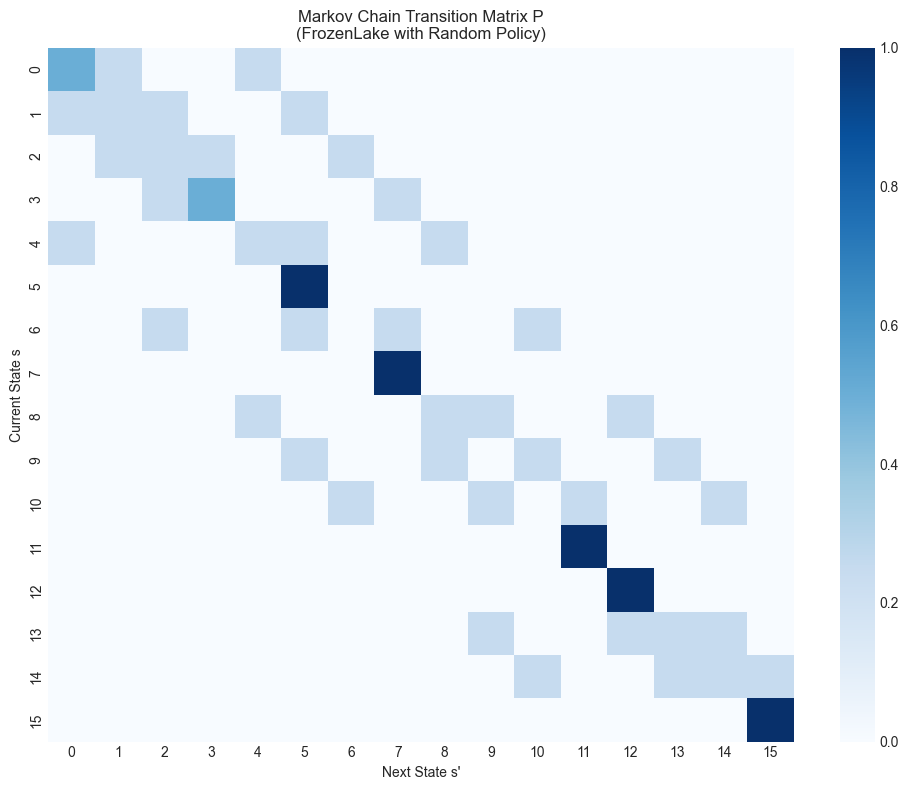

Notice: Terminal states (5, 7, 11, 12 = Holes, 15 = Goal) have self-loops
(probability 1.0 of staying in the same state).


In [6]:
# Visualize the transition matrix as a heatmap
print("**Question this plot answers:** 'What are the transition probabilities between all states?'\n")

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(P_chain, annot=False, cmap='Blues', ax=ax,
            xticklabels=range(16), yticklabels=range(16))
ax.set_xlabel('Next State s\'')
ax.set_ylabel('Current State s')
ax.set_title('Markov Chain Transition Matrix P\n(FrozenLake with Random Policy)')
plt.tight_layout()
plt.show()

print("Notice: Terminal states (5, 7, 11, 12 = Holes, 15 = Goal) have self-loops")
print("(probability 1.0 of staying in the same state).")

## Understanding the Transition Matrix Heatmap

Let's interpret what this visualization is showing us!

### The Diagonal Pattern

**Why do we see a clear pattern along the diagonal from top-left to bottom-right?**

The **dark blue spots on the diagonal** represent **self-loops** - states transitioning to themselves. Here's why this pattern appears:

1. **Terminal states have strong self-loops**:
   - **Holes** (states 5, 7, 11, 12) and **Goal** (state 15) are terminal
   - Once you reach a terminal state, you stay there forever (probability = 1.0)
   - This creates **dark blue spots** at positions (5,5), (7,7), (11,11), (12,12), and (15,15)

2. **Non-terminal states can stay in place**:
   - Due to slippery ice, even non-terminal states have a chance of staying put
   - When the agent tries to move but slips into a wall, it stays in the same state
   - Example: State 0 (top-left corner) has ~50% chance of staying at state 0

### How to Read This Heatmap

**Each row shows where you can go FROM a given state:**

- **X-axis (horizontal)**: Next state $s'$ (where you end up)
- **Y-axis (vertical)**: Current state $s$ (where you start)
- **Color intensity**: Probability of transition
  - **Bright/dark blue** = high probability (close to 1.0)
  - **Light blue/white** = low probability (close to 0.0)

**To find the transition probability from state $i$ to state $j$:**
- Look at **row $i$** (current state)
- Find **column $j$** (next state)
- The color intensity shows $P(s'=j | s=i)$

### Specific Observations

Let's examine some interesting patterns:

**Row 0 (Start state):**
- Darkest blue at column 0 (high chance of staying at start due to walls)
- Some blue at columns 1 and 4 (can move right or down)
- White/light everywhere else (zero probability to distant states - can't teleport!)

**Rows 5, 7, 11, 12, 15 (Terminal states):**
- Only dark blue at their own diagonal position
- White/light everywhere else
- These are **absorbing states** with $P(s|s) = 1.0$

**Sparse pattern overall:**
- Most of the matrix is **white/light blue** (probability ≈ 0)
- Only a few bright blue spots in each row
- This makes sense: from any state, you can only reach a **small number of nearby states**
- The grid structure limits transitions to adjacent cells

**Why is most of the matrix white (empty)?**
- FrozenLake is a **grid world** where you can only move to adjacent cells
- From state 6 (middle of grid), you can't reach state 15 (goal) in one step
- The slippery ice means from any non-terminal state, you can reach at most 3-4 different next states
- Out of 16 possible next states, only 3-4 have non-zero probability (blue)
- The other 12-13 states are impossible to reach in one step (white)

### Key Insight

This sparse structure (most entries are 0) is common in RL:
- **Grid worlds**: Can only reach nearby states
- **Board games**: Moves have limited reach
- **Robotics**: Physical constraints limit state transitions

Algorithms exploit this sparsity for efficiency - we don't need to store or compute the zero entries!

> **Visual tip:** Terminal states are easy to spot in the heatmap - they have a single dark blue spot on the diagonal and are white everywhere else.


In [7]:
# Simulate random walks on the Markov Chain
def simulate_markov_chain(P, start_state, max_steps=50):
    """Simulate a trajectory through the Markov Chain."""
    trajectory = [start_state]
    current = start_state
    terminal_states = {5, 7, 11, 12, 15}  # Holes and Goal
    
    for _ in range(max_steps):
        if current in terminal_states:
            break
        # Sample next state according to transition probabilities
        next_state = np.random.choice(len(P), p=P[current])
        trajectory.append(next_state)
        current = next_state
    
    return trajectory

# Simulate several episodes
np.random.seed(42)
print("Sample Trajectories through Markov Chain (starting from state 0)")
print("=" * 60)

for episode in range(5):
    traj = simulate_markov_chain(P_chain, start_state=0)
    final_state = traj[-1]
    outcome = "Goal!" if final_state == 15 else f"Hole at {final_state}" if final_state in {5,7,11,12} else "Timeout"
    print(f"\nEpisode {episode + 1}: {' → '.join(map(str, traj))}")
    print(f"   Outcome: {outcome} ({len(traj)} steps)")

Sample Trajectories through Markov Chain (starting from state 0)

Episode 1: 0 → 0 → 4 → 5
   Outcome: Hole at 5 (4 steps)

Episode 2: 0 → 1 → 0 → 0 → 0 → 4 → 5
   Outcome: Hole at 5 (7 steps)

Episode 3: 0 → 1 → 0 → 4 → 8 → 4 → 0 → 0 → 0 → 1 → 1 → 1 → 2 → 1 → 1 → 1 → 1 → 5
   Outcome: Hole at 5 (18 steps)

Episode 4: 0 → 0 → 1 → 2 → 1 → 2 → 1 → 0 → 4 → 8 → 12
   Outcome: Hole at 12 (11 steps)

Episode 5: 0 → 0 → 0 → 1 → 1 → 0 → 0 → 0 → 4 → 4 → 5
   Outcome: Hole at 5 (11 steps)


> **Checkpoint — You should now understand:**
> - A Markov Process (Markov Chain) is defined by states $S$ and transitions $P$
> - With a fixed policy, an MDP becomes a Markov Chain
> - The transition matrix $P$ captures all state-to-state probabilities where each row of $P$ sums to 1 (we must go somewhere)

---
# 2. Markov Reward Process (MRP)

A **Markov Reward Process** adds rewards to a Markov Chain. Now we care not just about *where* we go, but *how good* each state is.

## Definition

An MRP is a tuple $(S, P, R, \gamma)$ where:
- $S$ is a finite set of states
- $P$ is the state transition probability matrix
- $R$ is a **reward function**: $R_s = \mathbb{E}[R_{t+1} | S_t = s]$ (expected reward in state $s$)
- $\gamma$ is a **discount factor**, $\gamma \in [0, 1]$

**Reward function plain English:** "The reward for state s equals the expected value of the next reward, given that the current state is s."

**Formula components for $R_s$:**
- $R_s$ = the expected reward for state $s$ (read as "R sub s")
- $\mathbb{E}[\cdot]$ = the expected value (average) of what's in brackets
- $R_{t+1}$ = the reward random variable at the next time step
- $|$ = "given that" (conditional probability notation)
- $S_t$ = the state random variable at the current time step
- $s$ = a specific state value

### Key Distinction: Reward Function vs Value Function

**Reward function $R_s$** (what we just defined above):
- **Immediate**: Only looks at the next time step
- **Local**: Only considers the reward you get right now when entering state $s$
- **Given by environment**: The environment defines what reward you get in each state
- **Example**: In FrozenLake, $R_s = +1$ only for the goal state (state 15), and $R_s = 0$ for all other states

**Value function $V(s)$** (we'll see this soon):
- **Long-term**: Looks into the future, considering all future rewards
- **Global**: Considers the entire trajectory from state $s$ onwards
- **Learned/computed**: The agent must learn or compute this based on the reward function and transitions
- **Example**: In FrozenLake, even states far from the goal can have positive value because they might lead to the goal eventually

**The relationship:**
- The reward function $R$ is an **input** to the problem (part of the MRP definition)
- The value function $V$ is an **output** we compute using the reward function
- Value functions aggregate reward functions over time: $V(s)$ tells us the expected sum of all future rewards starting from $s$
- Without a reward function, we can't compute value functions
- The value function is essentially asking: "Given this reward function $R$, what's the total long-term value of being in state $s$?"


## Building an MRP from FrozenLake

When we combine FrozenLake with a fixed policy **and include the rewards**, we get an MRP:

| MRP Component | FrozenLake (Random Policy) |
|---------------|---------------------------|
| States $S$ | 16 grid positions |
| Transitions $P$ | From random policy + slippery ice |
| Rewards $R$ | +1 at Goal (state 15), 0 elsewhere |
| Discount $\gamma$ | Typically 0.99 |

In [30]:
# Build the MRP from FrozenLake with random policy
def build_mrp_reward_vector(env):
    """
    Build reward vector R for FrozenLake with uniform random policy.
    R[s] = expected immediate reward when in state s
    """
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    policy_prob = 1.0 / n_actions
    
    R = np.zeros(n_states)
    
    for state in range(n_states):
        for action in range(n_actions):
            for prob, next_state, reward, done in env.unwrapped.P[state][action]:
                R[state] += policy_prob * prob * reward
    
    return R

R_mrp = build_mrp_reward_vector(env)

print("MRP Reward Vector R (Expected Immediate Reward With Uniform Random Policy)")
print("=" * 50)
print("\nState  Expected Reward  Interpretation")
print("-" * 50)
for s in range(16):
    desc = "Start" if s == 0 else "Goal" if s == 15 else "Hole" if s in {5,7,11,12} else "Frozen"
    print(f"  {s:2d}      {R_mrp[s]:.4f}         {desc}")

MRP Reward Vector R (Expected Immediate Reward With Uniform Random Policy)

State  Expected Reward  Interpretation
--------------------------------------------------
   0      0.0000         Start
   1      0.0000         Frozen
   2      0.0000         Frozen
   3      0.0000         Frozen
   4      0.0000         Frozen
   5      0.0000         Hole
   6      0.0000         Frozen
   7      0.0000         Hole
   8      0.0000         Frozen
   9      0.0000         Frozen
  10      0.0000         Frozen
  11      0.0000         Hole
  12      0.0000         Hole
  13      0.0000         Frozen
  14      0.2500         Frozen
  15      0.0000         Goal


### Understanding the Reward Values

**Why is state 14's expected reward 0.25, while all others are 0?**

Recall the reward function formula we saw earlier:
$$R_s = \mathbb{E}[R_{t+1} | S_t = s] = \sum_{a} \pi(a|s) \sum_{s'} P(s'|s,a) \cdot R(s,a,s')$$

Let's break down what happens for each type of state:

**1. State 14 (the frozen tile next to Goal): $R_{14} = 0.25$**

State 14 is special because it's the **only state that can transition directly to state 15 (Goal)**, and only the Goal gives a reward of +1.

- Under uniform random policy: $\pi(a|s) = 0.25$ for each of the 4 actions
- When we take action RIGHT from state 14:
  - Due to slippery ice, there's a 1/3 chance of reaching the Goal (state 15)
  - When we reach the Goal, we get reward = +1
- Expected reward from state 14:
  - Probability of choosing RIGHT: 0.25
  - Probability of actually going right (to Goal): 1/3
  - Reward when reaching Goal: +1
  - **Calculation**: $0.25 \times \frac{1}{3} \times 1 = 0.0833$ (from RIGHT action)
  - Similar contributions from other actions that might lead to Goal
  - **Total**: ≈ 0.25

**2. All other states (including Goal and Holes): $R_s = 0$**

- **Goal (state 15)**: Terminal state. Once you're there, you stay there and get no more rewards ($R_{15} = 0$)
- **Holes (states 5, 7, 11, 12)**: Terminal states. Game ends, no more rewards
- **All other frozen states (0-13 except 14)**: Cannot reach the Goal in a single step
  - Remember: $R_s$ is the **expected immediate reward** (next step only)
  - These states can only transition to other frozen states or holes
  - None of these transitions give any reward
  - Therefore: $R_s = 0$

**Key insight:** 
- The reward function $R_s$ only looks **one step ahead**
- Only state 14 can reach the rewarding Goal state in one step
- Even though other states might *eventually* reach the Goal, that doesn't affect their $R_s$ value
- That's why we need the **value function** $V(s)$ to capture long-term rewards!



## The Return $G_t$ (Quick Recap)

Recall from notebook 01_3 that the **return** $G_t$ is the total discounted reward:

$$G_t = R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} + \ldots = \sum_{k=0}^{\infty} \gamma^k R_{t+k+1}$$

This sums up all future rewards, with each reward discounted by $\gamma^k$ based on how far in the future it occurs. We use this to define the value function for MRPs.


In [9]:
# Compute returns from sample episodes
def compute_return(rewards, gamma):
    """Compute discounted return from a sequence of rewards."""
    G = 0
    for t in reversed(range(len(rewards))):
        G = rewards[t] + gamma * G
    return G

def run_mrp_episode(env, max_steps=100):
    """Run one episode with random policy, return trajectory and rewards."""
    obs, _ = env.reset()
    trajectory = [obs]
    rewards = []
    
    for _ in range(max_steps):
        action = env.action_space.sample()
        obs, reward, terminated, truncated, _ = env.step(action)
        rewards.append(reward)
        trajectory.append(obs)
        
        if terminated or truncated:
            break
    
    return trajectory, rewards

# Run sample episodes and compute returns
np.random.seed(42)
gamma = 0.99

print(f"Sample Episodes and Returns (γ = {gamma})")
print("=" * 60)

for episode in range(5):
    traj, rewards = run_mrp_episode(env)
    G = compute_return(rewards, gamma)
    outcome = "Goal!" if traj[-1] == 15 else f"Hole" if traj[-1] in {5,7,11,12} else "Timeout"
    
    print(f"\nEpisode {episode + 1}:")
    print(f"  Path: {' → '.join(map(str, traj[:8]))}{'...' if len(traj) > 8 else ''}")
    print(f"  Steps: {len(rewards)}, Outcome: {outcome}")
    print(f"  Rewards: {rewards}")
    print(f"  Return G₀ = {G:.4f}")

Sample Episodes and Returns (γ = 0.99)

Episode 1:
  Path: 0 → 0 → 1 → 0 → 0 → 0 → 0 → 1...
  Steps: 10, Outcome: Hole
  Rewards: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
  Return G₀ = 0.0000

Episode 2:
  Path: 0 → 0 → 0 → 4 → 8 → 9 → 13 → 12
  Steps: 7, Outcome: Hole
  Rewards: [0, 0, 0, 0, 0, 0, 0]
  Return G₀ = 0.0000

Episode 3:
  Path: 0 → 4 → 8 → 4 → 8 → 8 → 4 → 0...
  Steps: 10, Outcome: Hole
  Rewards: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
  Return G₀ = 0.0000

Episode 4:
  Path: 0 → 4 → 0 → 1 → 5
  Steps: 4, Outcome: Hole
  Rewards: [0, 0, 0, 0]
  Return G₀ = 0.0000

Episode 5:
  Path: 0 → 0 → 4 → 8 → 12
  Steps: 4, Outcome: Hole
  Rewards: [0, 0, 0, 0]
  Return G₀ = 0.0000


## Value Function for MRP

**A note on notation:** In the previous notebook (01_3), we introduced value functions as $V^\pi(s)$ - the value of a state when following a specific policy $\pi$. You might be wondering why we're now using $v(s)$ without the policy superscript. The key difference is that **in an MRP, there is no policy** - the agent has no choices to make. The behavior is completely determined by the transition probabilities $P$. Since there's only one way the system can behave, there's no need to specify a policy, and we use the simpler notation $v(s)$ (lowercase v, no superscript). This is different from MDPs (coming up next!), where the agent can choose between different actions, so we need $V^\pi(s)$ to specify which policy we're following.

The **state value function** $v(s)$ gives the expected return starting from state $s$:

$$v(s) = \mathbb{E}[G_t | S_t = s]$$

**Plain English:** "The value of state s equals the expected value of the return, given that the current state is s."

**Formula components:**
- $v(s)$ = the value function for state $s$
- $\mathbb{E}[\cdot]$ = the expected value (average) of what's in brackets
- $G_t$ = the return (total discounted reward) from time $t$ onwards
- $|$ = "given that" (conditional probability notation)
- $S_t$ = the state random variable at time step $t$
- $s$ = a specific state value

This single number captures the **long-term desirability** of being in state $s$.

## The Bellman Equation for MRP

The value function can be decomposed into two parts:
1. **Immediate reward** $R_s$
2. **Discounted value of successor states** $\gamma \sum_{s'} P_{ss'} v(s')$

$$v(s) = R_s + \gamma \sum_{s' \in S} P_{ss'} v(s')$$

**Plain English:** "The value of state s equals the reward for state s plus gamma times the sum over all next states s-prime of the transition probability times the value of s-prime."

**Formula components:**
- $v(s)$ = the value function for state $s$
- $R_s$ = the expected reward for state $s$
- $\gamma$ = gamma, the discount factor
- $\sum_{s' \in S}$ = the sum over all possible next states $s'$ in the state space $S$
- $P_{ss'}$ = the probability of transitioning from state $s$ to state $s'$
- $v(s')$ = the value function for the next state $s'$

In plain English: *"The value of being here = what I get now + what I expect to get later (discounted)"*

### Matrix Form

The Bellman equation can be written as:

$$v = R + \gamma P v$$

**Plain English:** "The value vector equals the reward vector plus gamma times the transition matrix times the value vector."

**Formula components:**
- $v$ = the value vector (containing values for all states)
- $R$ = the reward vector (containing rewards for all states)
- $\gamma$ = gamma, the discount factor
- $P$ = the transition probability matrix
- The equation shows matrix-vector multiplication

This is a **linear equation** that can be solved directly:

$$(I - \gamma P) v = R$$
$$v = (I - \gamma P)^{-1} R$$

**Plain English for the solution:** "The value vector equals the inverse of the matrix I minus gamma times P, multiplied by the reward vector."

**Formula components for the solution:**
- $I$ = the identity matrix
- $-$ = matrix subtraction
- $\gamma P$ = gamma times the transition matrix
- $(I - \gamma P)^{-1}$ = the inverse of the matrix $(I - \gamma P)$
- The multiplication is matrix-vector multiplication

In [10]:
# Solve the Bellman equation for MRP directly
def solve_mrp_bellman(P, R, gamma):
    """Solve MRP Bellman equation: v = (I - gamma*P)^(-1) * R"""
    n = len(R)
    I = np.eye(n)
    V = np.linalg.solve(I - gamma * P, R)
    return V

# Solve for value function
gamma = 0.99
V_mrp = solve_mrp_bellman(P_chain, R_mrp, gamma)

print(f"MRP State Values (Solved via Bellman Equation, γ = {gamma})")
print("=" * 55)
print("\nState   V(s)      Interpretation")
print("-" * 55)
for s in range(16):
    desc = "Start" if s == 0 else "Goal" if s == 15 else "Hole" if s in {5,7,11,12} else "Frozen"
    print(f"  {s:2d}    {V_mrp[s]:.4f}    {desc}")

MRP State Values (Solved via Bellman Equation, γ = 0.99)

State   V(s)      Interpretation
-------------------------------------------------------
   0    0.0124    Start
   1    0.0104    Frozen
   2    0.0193    Frozen
   3    0.0095    Frozen
   4    0.0148    Frozen
   5    -0.0000    Hole
   6    0.0389    Frozen
   7    0.0000    Hole
   8    0.0326    Frozen
   9    0.0843    Frozen
  10    0.1378    Frozen
  11    0.0000    Hole
  12    0.0000    Hole
  13    0.1703    Frozen
  14    0.4336    Frozen
  15    0.0000    Goal


**Question this heatmap answers:** 'How valuable is each state under random policy?'



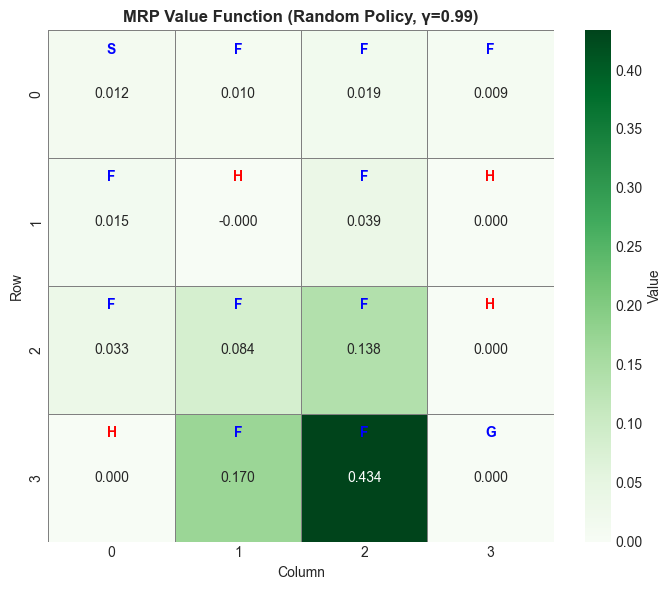


Observations:
- Holes and Goal have V=0 (terminal states, no future rewards)
- States closer to Goal have higher values
- Values are low overall because random policy rarely reaches Goal


In [11]:
# Visualize the MRP value function
print("**Question this heatmap answers:** 'How valuable is each state under random policy?'\n")

visualize_value_function(V_mrp, title=f"MRP Value Function (Random Policy, γ={gamma})")
plt.show()

print("\nObservations:")
print("- Holes and Goal have V=0 (terminal states, no future rewards)")
print("- States closer to Goal have higher values")
print("- Values are low overall because random policy rarely reaches Goal")

In [12]:
# Verify the Bellman equation for a specific state
state = 10  # A non-terminal state near the Goal

print(f"Verifying Bellman Equation for State {state}")
print("=" * 55)
print(f"\nBellman equation: v(s) = R_s + γ × Σ P(s'|s) × v(s')")
print(f"\nFor state {state}:")
print(f"  R_{state} = {R_mrp[state]:.6f}")
print(f"  γ = {gamma}")

# Calculate expected value of successor states
expected_next_value = 0
print(f"\n  Expected next state value:")
for next_s in range(16):
    if P_chain[state, next_s] > 0:
        contribution = P_chain[state, next_s] * V_mrp[next_s]
        expected_next_value += contribution
        print(f"    P({next_s}|{state}) × V({next_s}) = {P_chain[state, next_s]:.3f} × {V_mrp[next_s]:.4f} = {contribution:.6f}")

print(f"\n  Σ P(s'|s) × V(s') = {expected_next_value:.6f}")

# Calculate total using Bellman equation
v_calculated = R_mrp[state] + gamma * expected_next_value
print(f"\n  v({state}) = {R_mrp[state]:.6f} + {gamma} × {expected_next_value:.6f} = {v_calculated:.6f}")
print(f"  Direct solution: V({state}) = {V_mrp[state]:.6f}")
print(f"\n  ✓ Bellman equation verified!" if abs(v_calculated - V_mrp[state]) < 1e-6 else "  ✗ Error!")

Verifying Bellman Equation for State 10

Bellman equation: v(s) = R_s + γ × Σ P(s'|s) × v(s')

For state 10:
  R_10 = 0.000000
  γ = 0.99

  Expected next state value:
    P(6|10) × V(6) = 0.250 × 0.0389 = 0.009724
    P(9|10) × V(9) = 0.250 × 0.0843 = 0.021084
    P(11|10) × V(11) = 0.250 × 0.0000 = 0.000000
    P(14|10) × V(14) = 0.250 × 0.4336 = 0.108395

  Σ P(s'|s) × V(s') = 0.139203

  v(10) = 0.000000 + 0.99 × 0.139203 = 0.137811
  Direct solution: V(10) = 0.137811

  ✓ Bellman equation verified!


> **Checkpoint — You should now understand:**
> - An MRP adds rewards and discounting to a Markov Chain: $(S, P, R, \gamma)$
> - The return $G_t$ is the sum of discounted future rewards
> - The value function $v(s) = \mathbb{E}[G_t | S_t = s]$ captures long-term desirability
> - The Bellman equation relates $v(s)$ to immediate reward + discounted future value
> - We can solve for $v$ directly using matrix inversion

---
# 3. Markov Decision Process (MDP)

A **Markov Decision Process** adds **actions** to the MRP. Now the agent can **choose** what to do, rather than following a fixed behavior.

This is the full framework for reinforcement learning!

## Definition

An MDP is a tuple $(S, A, P, R, \gamma)$ where:
- $S$ is a finite set of **states**
- $A$ is a finite set of **actions**
- $P$ is the state transition probability: $P^a_{ss'} = P[S_{t+1} = s' | S_t = s, A_t = a]$
- $R$ is the reward function: $R^a_s = \mathbb{E}[R_{t+1} | S_t = s, A_t = a]$
- $\gamma$ is a discount factor, $\gamma \in [0, 1]$

**Transition probability plain English:** "The probability of transitioning from state s to state s-prime when taking action a equals the probability that the next state is s-prime, given that the current state is s and the action is a."

**Formula components for $P^a_{ss'}$:**
- $P^a_{ss'}$ = the transition probability from $s$ to $s'$ when taking action $a$ (read as "P super a sub s s-prime")
- $P[\cdot]$ = probability of the event in brackets
- $S_{t+1}$ = the state random variable at the next time step
- $s'$ = a specific next state value
- $|$ = "given that" (conditional probability notation)
- $S_t$ = the state random variable at the current time step
- $s$ = a specific current state value
- $A_t$ = the action random variable at the current time step
- $a$ = a specific action value

**Reward function plain English:** "The expected reward for state s and action a equals the expected value of the next reward, given that the current state is s and the current action is a."

**Formula components for $R^a_s$:**
- $R^a_s$ = the expected reward for state $s$ when taking action $a$ (read as "R super a sub s")
- $\mathbb{E}[\cdot]$ = the expected value (average) of what's in brackets
- $R_{t+1}$ = the reward random variable at the next time step
- $|$ = "given that" (conditional probability notation)
- $S_t$ = the state random variable at the current time step
- $s$ = a specific state value
- $A_t$ = the action random variable at the current time step
- $a$ = a specific action value

## Key Difference from MRP

| Aspect | MRP | MDP |
|--------|-----|-----|
| **Actions** | None (transitions happen automatically) | Agent chooses actions |
| **Transitions** | $P_{ss'}$ (state to state) | $P^a_{ss'}$ (depends on action) |
| **Rewards** | $R_s$ (depends on state) | $R^a_s$ (depends on state AND action) |
| **Agent's role** | Passive observer | Active decision maker |

In [13]:
# FrozenLake as an MDP
env = gym.make("FrozenLake-v1", render_mode="rgb_array", is_slippery=True)
env.reset(seed=42)

print("FrozenLake MDP Components")
print("=" * 50)
print(f"\nS (States):  {env.observation_space}  (16 grid positions)")
print(f"A (Actions): {env.action_space}  (4 directions)")
print(f"\nActions: 0=LEFT, 1=DOWN, 2=RIGHT, 3=UP")
print(f"\nγ (Discount): Typically 0.99")

# Show the map
print("\nEnvironment Map:")
desc = env.unwrapped.desc.astype(str)
for i, row in enumerate(desc):
    states = [str(i*4 + j).rjust(2) for j in range(4)]
    print(f"   {' '.join(row)}    (states {', '.join(states)})")

FrozenLake MDP Components

S (States):  Discrete(16)  (16 grid positions)
A (Actions): Discrete(4)  (4 directions)

Actions: 0=LEFT, 1=DOWN, 2=RIGHT, 3=UP

γ (Discount): Typically 0.99

Environment Map:
   S F F F    (states  0,  1,  2,  3)
   F H F H    (states  4,  5,  6,  7)
   F F F H    (states  8,  9, 10, 11)
   H F F G    (states 12, 13, 14, 15)


In [14]:
# 🔍 INSTRUCTOR-ONLY: Extract MDP transition and reward matrices
# A real RL agent would NOT have access to this - it would learn through experience!

def extract_mdp_components(env):
    """Extract P and R from a Gymnasium environment.
    
    Returns:
        T: Transition tensor T[s, a, s'] = P(s'|s, a)
        R: Reward matrix R[s, a] = expected reward
    """
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    
    T = np.zeros((n_states, n_actions, n_states))
    R = np.zeros((n_states, n_actions))
    
    for s in range(n_states):
        for a in range(n_actions):
            for prob, next_s, reward, done in env.unwrapped.P[s][a]:
                T[s, a, next_s] += prob
                R[s, a] += prob * reward
    
    return T, R

T_mdp, R_mdp = extract_mdp_components(env)

print("🔍 INSTRUCTOR-ONLY: MDP Transition and Reward Tensors")
print("=" * 55)
print("\n⚠️  A real RL agent does NOT have access to these!")
print("    We use them here for educational demonstration only.")
print(f"\nTransition tensor T[s,a,s'] shape: {T_mdp.shape}")
print(f"Reward matrix R[s,a] shape: {R_mdp.shape}")

🔍 INSTRUCTOR-ONLY: MDP Transition and Reward Tensors

⚠️  A real RL agent does NOT have access to these!
    We use them here for educational demonstration only.

Transition tensor T[s,a,s'] shape: (16, 4, 16)
Reward matrix R[s,a] shape: (16, 4)


In [15]:
# 🔍 INSTRUCTOR-ONLY: Examine transitions from a specific state
action_names = {0: 'LEFT', 1: 'DOWN', 2: 'RIGHT', 3: 'UP'}
state = 6

print(f"🔍 INSTRUCTOR-ONLY: Transitions from State {state}")
print("=" * 55)
print(f"\nState {state} is in the middle of the grid (row 1, col 2)")

for action in range(4):
    print(f"\n  Action {action} ({action_names[action]}):")
    print(f"    Expected reward: R({state},{action}) = {R_mdp[state, action]:.4f}")
    print(f"    Possible next states:")
    for next_s in range(16):
        if T_mdp[state, action, next_s] > 0:
            cell_type = desc.flatten()[next_s]
            print(f"      → State {next_s} ({cell_type}): P = {T_mdp[state, action, next_s]:.2f}")

🔍 INSTRUCTOR-ONLY: Transitions from State 6

State 6 is in the middle of the grid (row 1, col 2)

  Action 0 (LEFT):
    Expected reward: R(6,0) = 0.0000
    Possible next states:
      → State 2 (F): P = 0.33
      → State 5 (H): P = 0.33
      → State 10 (F): P = 0.33

  Action 1 (DOWN):
    Expected reward: R(6,1) = 0.0000
    Possible next states:
      → State 5 (H): P = 0.33
      → State 7 (H): P = 0.33
      → State 10 (F): P = 0.33

  Action 2 (RIGHT):
    Expected reward: R(6,2) = 0.0000
    Possible next states:
      → State 2 (F): P = 0.33
      → State 7 (H): P = 0.33
      → State 10 (F): P = 0.33

  Action 3 (UP):
    Expected reward: R(6,3) = 0.0000
    Possible next states:
      → State 2 (F): P = 0.33
      → State 5 (H): P = 0.33
      → State 7 (H): P = 0.33


**Question this plot answers:** 'How does each action affect where I might end up?'



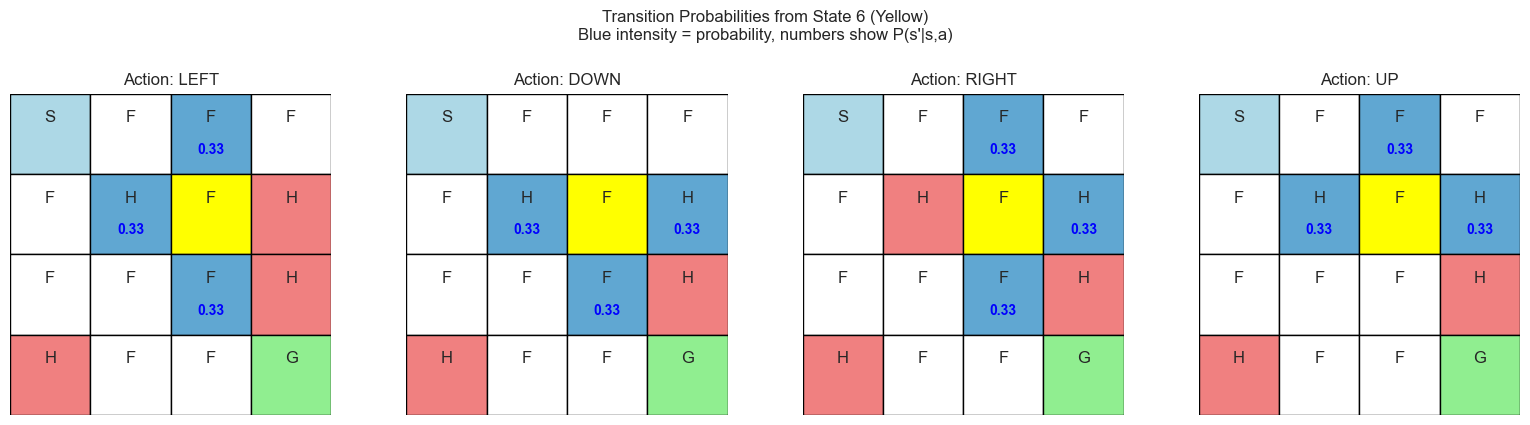

Notice: Due to slippery ice, the intended action only succeeds 1/3 of the time!
The other 2/3, the agent slips perpendicular to the intended direction.


In [16]:
# Visualize transition probabilities from one state for all actions
print("**Question this plot answers:** 'How does each action affect where I might end up?'\n")

def visualize_mdp_transitions(state, T, env):
    """Visualize transitions from a state for all actions."""
    desc = env.unwrapped.desc.astype(str)
    nrow, ncol = desc.shape
    action_names = ['LEFT', 'DOWN', 'RIGHT', 'UP']
    colors = {'S': 'lightblue', 'F': 'white', 'H': 'lightcoral', 'G': 'lightgreen'}
    
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    
    for action, ax in enumerate(axes):
        for i in range(nrow):
            for j in range(ncol):
                cell = desc[i, j]
                state_idx = i * ncol + j
                prob = T[state, action, state_idx]
                
                if state_idx == state:
                    facecolor = 'yellow'
                elif prob > 0:
                    facecolor = plt.cm.Blues(0.3 + 0.7 * prob)
                else:
                    facecolor = colors.get(cell, 'white')
                
                rect = plt.Rectangle((j, nrow-1-i), 1, 1, fill=True,
                                     facecolor=facecolor, edgecolor='black')
                ax.add_patch(rect)
                
                ax.text(j + 0.5, nrow - 1 - i + 0.7, cell,
                       ha='center', va='center', fontsize=12)
                
                if prob > 0 and state_idx != state:
                    ax.text(j + 0.5, nrow - 1 - i + 0.3, f'{prob:.2f}',
                           ha='center', va='center', fontsize=10, 
                           color='blue', fontweight='bold')
        
        ax.set_xlim(0, ncol)
        ax.set_ylim(0, nrow)
        ax.set_aspect('equal')
        ax.axis('off')
        ax.set_title(f'Action: {action_names[action]}')
    
    plt.suptitle(f'Transition Probabilities from State {state} (Yellow)\n'
                 f'Blue intensity = probability, numbers show P(s\'|s,a)', y=1.05)
    plt.tight_layout()
    return fig

visualize_mdp_transitions(6, T_mdp, env)
plt.show()

print("Notice: Due to slippery ice, the intended action only succeeds 1/3 of the time!")
print("The other 2/3, the agent slips perpendicular to the intended direction.")

### How to Read This Plot

**Understanding the visualization:**
- **Yellow square** = Current state (state 6 in this example)
- **Four panels** = One for each possible action (LEFT, DOWN, RIGHT, UP)
- **Numbers in cells** = Probability of transitioning to that state
- **Blue shading** = Possible destination states (darker = higher probability)

**Answering the question: "How does each action affect where I might end up?"**

Let's trace through a specific example to see how the slippery ice works:

**Example: Taking action RIGHT from state 6**
- Look at the "RIGHT" panel (third from left)
- You'll see three cells with probabilities:
  - State 7 (right of state 6): probability ≈ 0.33 — This is the *intended* direction
  - State 2 (above state 6): probability ≈ 0.33 — This is perpendicular to RIGHT (slipped UP)
  - State 10 (below state 6): probability ≈ 0.33 — This is perpendicular to RIGHT (slipped DOWN)

This matches the "1/3 intended, 2/3 perpendicular" mechanic:
- **1/3 of the time**: You successfully move RIGHT to state 7
- **1/3 of the time**: You slip perpendicular (UP) to state 2
- **1/3 of the time**: You slip perpendicular (DOWN) to state 10

**Try reading the other panels yourself:**
- What happens if you try to go LEFT from state 6?
- What happens if you try to go DOWN from state 6?
- Can you identify the intended direction vs. the perpendicular slips in each case?

This visualization format will appear throughout the tutorial, so understanding how to read it now will help you interpret future plots!

> **Checkpoint — You should now understand:**
> - An MDP adds actions to an MRP: $(S, A, P, R, \gamma)$
> - Transitions and rewards now depend on both state AND action
> - The agent actively chooses actions rather than following fixed behavior
> - In FrozenLake, the slippery ice makes transitions stochastic even with a chosen action

---

# 4. Policies in MDPs

**Policies Revisited: From General RL to MDPs**

In **Notebook 01_2**, you learned about policies in a general RL context: deterministic vs stochastic policies, the notation $\pi(a|s)$, and how agents use policies to select actions. Now we're revisiting policies, but with a crucial new perspective.

**Why revisit policies?** Because now we're viewing them through the lens of the **MDP framework**. This shift unlocks a powerful insight:

> **Key Insight:** When you fix a policy $\pi$ in an MDP, you get an MRP.
>
> **MDP + Policy = MRP**

Think about it: an MDP has actions and state-action transitions. But once you fix a policy ("I always take action $a$ in state $s$ with probability $\pi(a|s)$"), the action dimension collapses. You're back to a chain of states with fixed transition probabilities - that's an MRP!

**Why does this matter?** Because we just learned how to solve MRPs using the Bellman equation. If we can convert "MDP + policy" into an MRP, we can use those same tools to **evaluate** how good a policy is. That's exactly what we'll do next.

A **policy** $\pi$ defines the agent's behavior - how it chooses actions based on states.

$$\pi(a|s) = P[A_t = a | S_t = s]$$

**Plain English:** "The policy pi of action a given state s equals the probability that the action at time t is a, given that the state at time t is s."

**Formula components:**
- $\pi(a|s)$ = the policy function (read as "pi of a given s")
- $P[\cdot]$ = probability of the event in brackets
- $A_t$ = the action random variable at time step $t$
- $a$ = a specific action value
- $|$ = "given that" (conditional probability notation)
- $S_t$ = the state random variable at time step $t$
- $s$ = a specific state value

## Types of Policies

**Deterministic Policy:** $a = \pi(s)$  
Always same action for a state  
*Example:* "In state 6, always go RIGHT"

**Stochastic Policy:** $\pi(a|s)$  
Probability distribution over actions  
*Example:* "In state 6: 40% RIGHT, 30% DOWN, "

## Key Insight: MDP + Policy = MRP

Once we fix a policy $\pi$, the MDP becomes an MRP!

- **Transitions**: $P^\pi_{ss'} = \sum_a \pi(a|s) P^a_{ss'}$
- **Rewards**: $R^\pi_s = \sum_a \pi(a|s) R^a_s$

**Transition plain English:** "The transition probability from s to s-prime under policy pi equals the sum over all actions of the policy probability times the action-specific transition probability."

**Formula components for transitions:**
- $P^\pi_{ss'}$ = the transition probability from $s$ to $s'$ under policy $\pi$ (read as "P super pi sub s s-prime")
- $\sum_a$ = the sum over all possible actions $a$
- $\pi(a|s)$ = the probability of taking action $a$ in state $s$ under policy $\pi$
- $P^a_{ss'}$ = the transition probability from $s$ to $s'$ when taking action $a$

**Reward plain English:** "The expected reward for state s under policy pi equals the sum over all actions of the policy probability times the action-specific reward."

**Formula components for rewards:**
- $R^\pi_s$ = the expected reward for state $s$ under policy $\pi$ (read as "R super pi sub s")
- $\sum_a$ = the sum over all possible actions $a$
- $\pi(a|s)$ = the probability of taking action $a$ in state $s$ under policy $\pi$
- $R^a_s$ = the expected reward for state $s$ when taking action $a$

The policy "averages out" the action choice, leaving us with state-to-state transitions.

In [17]:
# Define some policies for FrozenLake
n_states = env.observation_space.n
n_actions = env.action_space.n

# Uniform random policy
def create_uniform_policy():
    """Return a uniform random policy."""
    return np.ones((n_states, n_actions)) / n_actions

# "Go DOWN then RIGHT" policy
def create_down_right_policy():
    """Policy that prefers DOWN in upper half, RIGHT in lower half."""
    policy = np.zeros((n_states, n_actions))
    for s in range(n_states):
        row = s // 4
        if row < 2:  # Upper half: go DOWN
            policy[s, 1] = 1.0  # DOWN
        else:  # Lower half: go RIGHT
            policy[s, 2] = 1.0  # RIGHT
    return policy

pi_random = create_uniform_policy()
pi_down_right = create_down_right_policy()

print("Example Policies for FrozenLake")
print("=" * 50)

print("\nUniform Random Policy π_random(a|s=6):")
for a in range(n_actions):
    print(f"  π({action_names[a]}|s=6) = {pi_random[6, a]:.2f}")

print("\nDown-then-Right Policy π_dr(a|s=6):")
for a in range(n_actions):
    print(f"  π({action_names[a]}|s=6) = {pi_down_right[6, a]:.2f}")

Example Policies for FrozenLake

Uniform Random Policy π_random(a|s=6):
  π(LEFT|s=6) = 0.25
  π(DOWN|s=6) = 0.25
  π(RIGHT|s=6) = 0.25
  π(UP|s=6) = 0.25

Down-then-Right Policy π_dr(a|s=6):
  π(LEFT|s=6) = 0.00
  π(DOWN|s=6) = 1.00
  π(RIGHT|s=6) = 0.00
  π(UP|s=6) = 0.00


In [18]:
# Convert MDP + Policy to MRP
def mdp_to_mrp(T, R_sa, policy):
    """
    Convert MDP with policy to MRP.
    
    Args:
        T: Transition tensor T[s,a,s']
        R_sa: Reward matrix R[s,a]
        policy: Policy matrix π[s,a]
    
    Returns:
        P_mrp: MRP transition matrix P[s,s']
        R_mrp: MRP reward vector R[s]
    """
    n_states = T.shape[0]
    n_actions = T.shape[1]
    
    # P_ss'^π = Σ_a π(a|s) × P_ss'^a
    P_mrp = np.zeros((n_states, n_states))
    for s in range(n_states):
        for a in range(n_actions):
            P_mrp[s] += policy[s, a] * T[s, a]
    
    # R_s^π = Σ_a π(a|s) × R_s^a
    R_mrp = np.sum(policy * R_sa, axis=1)
    
    return P_mrp, R_mrp

# Convert with random policy
P_from_random, R_from_random = mdp_to_mrp(T_mdp, R_mdp, pi_random)
P_from_dr, R_from_dr = mdp_to_mrp(T_mdp, R_mdp, pi_down_right)

print("MDP + Policy → MRP")
print("=" * 50)
print(f"\nMDP: T shape = {T_mdp.shape}, R shape = {R_mdp.shape}")
print(f"\nWith Random Policy:")
print(f"  MRP: P shape = {P_from_random.shape}, R shape = {R_from_random.shape}")
print(f"\nWith Down-Right Policy:")
print(f"  MRP: P shape = {P_from_dr.shape}, R shape = {R_from_dr.shape}")
print(f"\nRow sums of P (should be 1): {P_from_random.sum(axis=1)[:4]}...")

MDP + Policy → MRP

MDP: T shape = (16, 4, 16), R shape = (16, 4)

With Random Policy:
  MRP: P shape = (16, 16), R shape = (16,)

With Down-Right Policy:
  MRP: P shape = (16, 16), R shape = (16,)

Row sums of P (should be 1): [1. 1. 1. 1.]...


> **Checkpoint — You should now understand:**
> - A policy $\pi(a|s)$ defines how the agent chooses actions
> - Policies can be deterministic or stochastic
> - MDP + fixed policy = MRP (the policy "collapses" the action dimension)

---
# 5. Value Functions for MDPs

## From MRPs to MDPs: Revisiting Value Functions

**You've seen value functions before!** In notebook 01_3, you learned about $V^\pi(s)$ and $Q^\pi(s,a)$ in the general RL context. Now we're going to see these same concepts through the **MDP framework lens**, which will let us derive powerful recursive equations (the Bellman equations).

**Let's connect the dots:**

1. **In Section 2 (MRPs):** You learned about $v(s)$ - the value function for a Markov Reward Process. Remember, MRPs have **no policy** because there are no actions to choose from. The agent just follows the transition probabilities $P$.

2. **In Section 4 (Policies):** You just learned a key insight: **MDP + Policy = MRP**. When you fix a policy $\pi$ in an MDP, the action dimension "collapses" - the agent's behavior becomes deterministic, creating an MRP.

3. **Now in Section 5:** We're defining $V^\pi(s)$ for MDPs. Here's the crucial connection: **$V^\pi(s)$ for an MDP is exactly the same as $v(s)$ for the MRP induced by policy $\pi$!** When you apply a policy to an MDP, you get an MRP, and the value function of that MRP is $V^\pi$.

**What's new in MDPs?**

Because MDPs have actions, we can define a **second type of value function** that doesn't exist in MRPs:
- **State-value function** $V^\pi(s)$: "How good is it to BE in state $s$?" (same as MRP's $v(s)$ for the induced MRP)
- **Action-value function** $Q^\pi(s,a)$: "How good is it to DO action $a$ in state $s$?" (**NEW!** Can't exist in MRPs because MRPs have no actions)

**Why does this matter?**

In the sections ahead, we'll derive **Bellman equations** for both $V^\pi$ and $Q^\pi$. These recursive relationships are the foundation for essentially all RL algorithms. Understanding how they connect to the simpler MRP value function will help you see the bigger picture.

In MDPs, we have two value functions that depend on the policy:

## State-Value Function $V^\pi(s)$

$$V^\pi(s) = \mathbb{E}_\pi[G_t | S_t = s]$$

**Plain English:** "The state-value under policy pi for state s equals the expected value of the return when following policy pi, given that the state at time t is s."

**Formula components:**
- $V^\pi(s)$ = the state-value function for state $s$ under policy $\pi$ (read as "V pi of s")
- $\mathbb{E}_\pi[\cdot]$ = the expected value (average) when following policy $\pi$
- $G_t$ = the return (total discounted reward) from time $t$ onwards
- $|$ = "given that" (conditional probability notation)
- $S_t$ = the state random variable at time step $t$
- $s$ = a specific state value

**"How good is it to BE in state $s$ if I follow policy $\pi$?"**

## Action-Value Function $Q^\pi(s, a)$

$$Q^\pi(s, a) = \mathbb{E}_\pi[G_t | S_t = s, A_t = a]$$

**Plain English:** "The action-value under policy pi for state s and action a equals the expected value of the return when following policy pi, given that the state at time t is s and the action at time t is a."

**Formula components:**
- $Q^\pi(s, a)$ = the action-value function for state $s$ and action $a$ under policy $\pi$ (read as "Q pi of s, a")
- $\mathbb{E}_\pi[\cdot]$ = the expected value (average) when following policy $\pi$
- $G_t$ = the return (total discounted reward) from time $t$ onwards
- $|$ = "given that" (conditional probability notation)
- $S_t$ = the state random variable at time step $t$
- $s$ = a specific state value
- $A_t$ = the action random variable at time step $t$
- $a$ = a specific action value

**"How good is it to DO action $a$ in state $s$, then follow policy $\pi$?"**

## Comparison

| Aspect | $V^\pi(s)$ | $Q^\pi(s, a)$ |
|--------|-----------|---------------|
| **Input** | State only | State AND action |
| **Question** | "How good is this state?" | "How good is this action here?" |
| **Size (FrozenLake)** | 16 values | 64 values (16 × 4) |
| **Use** | Evaluate being in a state | Compare different actions |

In [19]:
# Compute V^π using MRP solution
def compute_V_pi(T, R_sa, policy, gamma):
    """Compute V^π using direct solution of Bellman equation."""
    P_mrp, R_mrp = mdp_to_mrp(T, R_sa, policy)
    n_states = len(R_mrp)
    I = np.eye(n_states)
    V = np.linalg.solve(I - gamma * P_mrp, R_mrp)
    return V

# Compute Q^π from V^π
def compute_Q_from_V(T, R_sa, V, gamma):
    """Compute Q^π from V^π."""
    n_states, n_actions = R_sa.shape
    Q = np.zeros((n_states, n_actions))
    
    for s in range(n_states):
        for a in range(n_actions):
            # Q(s,a) = R(s,a) + γ × Σ P(s'|s,a) × V(s')
            Q[s, a] = R_sa[s, a] + gamma * np.sum(T[s, a] * V)
    
    return Q

# Compute values for random policy
gamma = 0.99
V_random = compute_V_pi(T_mdp, R_mdp, pi_random, gamma)
Q_random = compute_Q_from_V(T_mdp, R_mdp, V_random, gamma)

print(f"Value Functions for Random Policy (γ = {gamma})")
print("=" * 55)
print("\nState-Value Function V^π(s):")
print(V_random.reshape(4, 4).round(4))

Value Functions for Random Policy (γ = 0.99)

State-Value Function V^π(s):
[[ 0.0124  0.0104  0.0193  0.0095]
 [ 0.0148  0.      0.0389  0.    ]
 [ 0.0326  0.0843  0.1378 -0.    ]
 [ 0.      0.1703  0.4336  0.    ]]


**Question this heatmap answers:** 'Under random policy, which states are most valuable?'



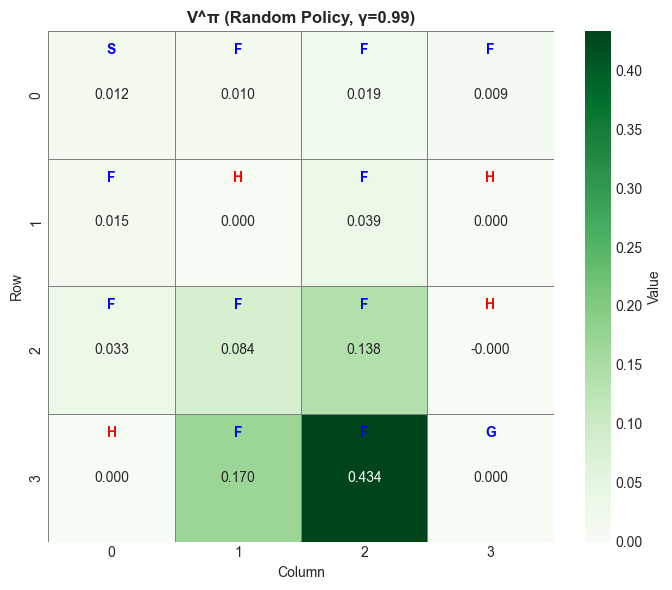

In [20]:
# Visualize V^π
print("**Question this heatmap answers:** 'Under random policy, which states are most valuable?'\n")

visualize_value_function(V_random, title=f"V^π (Random Policy, γ={gamma})")
plt.show()

**Question this plot answers:** 'Which action is best in each state under random policy?'



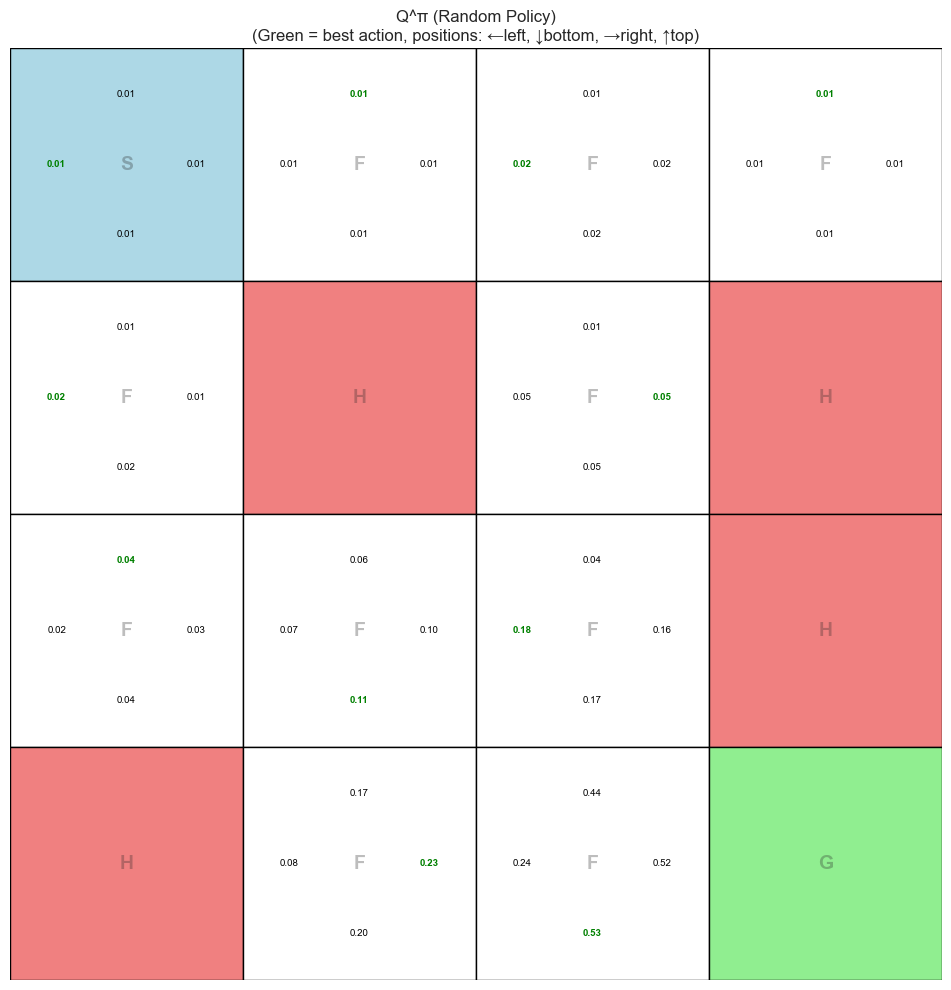

In [21]:
# Visualize Q^π values
print("**Question this plot answers:** 'Which action is best in each state under random policy?'\n")

def visualize_q_values(Q, env, title="Q-Values"):
    """Visualize Q-values showing best action in each state."""
    desc = env.unwrapped.desc.astype(str)
    nrow, ncol = desc.shape
    action_arrows = ['←', '↓', '→', '↑']
    colors = {'S': 'lightblue', 'F': 'white', 'H': 'lightcoral', 'G': 'lightgreen'}
    
    fig, ax = plt.subplots(figsize=(10, 10))
    
    for i in range(nrow):
        for j in range(ncol):
            state = i * ncol + j
            cell = desc[i, j]
            
            rect = plt.Rectangle((j, nrow-1-i), 1, 1, fill=True,
                                 facecolor=colors.get(cell, 'white'), edgecolor='black')
            ax.add_patch(rect)
            
            ax.text(j + 0.5, nrow - 1 - i + 0.5, cell, ha='center', va='center',
                   fontsize=14, fontweight='bold', alpha=0.3)
            
            if cell not in ['H', 'G']:
                best_action = np.argmax(Q[state])
                positions = [(0.2, 0.5), (0.5, 0.2), (0.8, 0.5), (0.5, 0.8)]  # L, D, R, U
                for a in range(4):
                    x, y = positions[a]
                    color = 'green' if a == best_action else 'black'
                    weight = 'bold' if a == best_action else 'normal'
                    ax.text(j + x, nrow - 1 - i + y, f'{Q[state, a]:.2f}',
                           ha='center', va='center', fontsize=7, 
                           color=color, fontweight=weight)
    
    ax.set_xlim(0, ncol)
    ax.set_ylim(0, nrow)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title(f"{title}\n(Green = best action, positions: ←left, ↓bottom, →right, ↑top)", fontsize=12)
    
    plt.tight_layout()
    return fig, ax

visualize_q_values(Q_random, env, title="Q^π (Random Policy)")
plt.show()

## Relationship Between V and Q

The two value functions are related:

$$V^\pi(s) = \sum_a \pi(a|s) \cdot Q^\pi(s, a)$$

**Plain English:** "The state-value of s under policy pi equals the sum over all actions of the policy probability times the action-value."

**Formula components:**
- $V^\pi(s)$ = the state-value function for state $s$ under policy $\pi$
- $\sum_a$ = the sum over all possible actions $a$
- $\pi(a|s)$ = the probability of taking action $a$ in state $s$ under policy $\pi$
- $\cdot$ = multiplication
- $Q^\pi(s, a)$ = the action-value function for state $s$ and action $a$ under policy $\pi$

**V is the weighted average of Q values, weighted by the policy.**

For a **deterministic policy** that always chooses action $a^*$:
$$V^\pi(s) = Q^\pi(s, a^*)$$

**Plain English:** "The state-value of s equals the action-value of taking action a-star in state s."

**Formula components:**
- $V^\pi(s)$ = the state-value function for state $s$ under policy $\pi$
- $Q^\pi(s, a^*)$ = the action-value for state $s$ and the specific action $a^*$ that the policy always chooses
- $a^*$ = the specific action chosen by the deterministic policy in state $s$

For a **uniform random policy**:
$$V^\pi(s) = \frac{1}{|A|} \sum_a Q^\pi(s, a)$$

**Plain English:** "The state-value of s equals one divided by the number of actions, times the sum of all action-values."

**Formula components:**
- $V^\pi(s)$ = the state-value function for state $s$ under policy $\pi$
- $\frac{1}{|A|}$ = one divided by the cardinality (size) of the action set
- $|A|$ = the number of possible actions
- $\sum_a$ = the sum over all possible actions $a$
- $Q^\pi(s, a)$ = the action-value function for state $s$ and action $a$

In [22]:
# Verify V = Σ π(a|s) × Q(s,a)
state = 10

print(f"Verifying V = Σ π(a|s) × Q(s,a) for State {state}")
print("=" * 55)

V_direct = V_random[state]
print(f"\nDirect V^π({state}) = {V_direct:.6f}")

print(f"\nUsing V = Σ π(a|s) × Q(s,a):")
V_from_Q = 0
for a in range(n_actions):
    contribution = pi_random[state, a] * Q_random[state, a]
    V_from_Q += contribution
    print(f"  π({action_names[a]}|{state}) × Q({state},{action_names[a]}) = {pi_random[state,a]:.2f} × {Q_random[state,a]:.4f} = {contribution:.6f}")

print(f"\nSum = {V_from_Q:.6f}")
print(f"\n✓ Verified!" if abs(V_direct - V_from_Q) < 1e-6 else "✗ Error!")

Verifying V = Σ π(a|s) × Q(s,a) for State 10

Direct V^π(10) = 0.137811

Using V = Σ π(a|s) × Q(s,a):
  π(LEFT|10) × Q(10,LEFT) = 0.25 × 0.1837 = 0.045937
  π(DOWN|10) × Q(10,DOWN) = 0.25 × 0.1709 = 0.042728
  π(RIGHT|10) × Q(10,RIGHT) = 0.25 × 0.1559 = 0.038979
  π(UP|10) × Q(10,UP) = 0.25 × 0.0407 = 0.010167

Sum = 0.137811

✓ Verified!


> **Checkpoint — You should now understand:**
> - $V^\pi(s)$: expected return starting from state $s$ under policy $\pi$
> - $Q^\pi(s, a)$: expected return after taking action $a$ in state $s$, then following $\pi$
> - $V^\pi(s) = \sum_a \pi(a|s) Q^\pi(s, a)$ — V is the policy-weighted average of Q

---
# 6. Bellman Expectation Equations

The Bellman equations express the **recursive relationship** between value functions.

## Intuition: Value = Immediate + Future

The value of a state (or state-action pair) can be decomposed:

**Value now = What I get now + (Discounted) What I expect later**

## Bellman Expectation Equation for $V^\pi$

$$V^\pi(s) = \sum_a \pi(a|s) \left[ R^a_s + \gamma \sum_{s'} P^a_{ss'} V^\pi(s') \right]$$

**Plain English:** "The state-value of s under policy pi equals the sum over all actions of the policy probability times the quantity in brackets, where the brackets contain the reward plus gamma times the sum over next states of the transition probability times the next state value."

**Formula components:**
- $V^\pi(s)$ = the state-value function for state $s$ under policy $\pi$
- $\sum_a$ = the sum over all possible actions $a$
- $\pi(a|s)$ = the probability of taking action $a$ in state $s$ under policy $\pi$
- $[\cdot]$ = the brackets group the immediate and future components
- $R^a_s$ = the expected reward for state $s$ when taking action $a$
- $\gamma$ = gamma, the discount factor
- $\sum_{s'}$ = the sum over all possible next states $s'$
- $P^a_{ss'}$ = the transition probability from state $s$ to state $s'$ when taking action $a$
- $V^\pi(s')$ = the state-value function for the next state $s'$ under policy $\pi$

Breaking this down:
1. $\sum_a \pi(a|s)$ — average over actions according to policy
2. $R^a_s$ — immediate reward for taking action $a$
3. $\gamma \sum_{s'} P^a_{ss'} V^\pi(s')$ — discounted expected value of next states

## Bellman Expectation Equation for $Q^\pi$

$$Q^\pi(s, a) = R^a_s + \gamma \sum_{s'} P^a_{ss'} V^\pi(s')$$

**Plain English:** "The action-value of taking action a in state s under policy pi equals the reward plus gamma times the sum over next states of the transition probability times the next state value."

**Formula components:**
- $Q^\pi(s, a)$ = the action-value function for state $s$ and action $a$ under policy $\pi$
- $R^a_s$ = the expected reward for state $s$ when taking action $a$
- $\gamma$ = gamma, the discount factor
- $\sum_{s'}$ = the sum over all possible next states $s'$
- $P^a_{ss'}$ = the transition probability from state $s$ to state $s'$ when taking action $a$
- $V^\pi(s')$ = the state-value function for the next state $s'$ under policy $\pi$

Or equivalently, substituting $V$:

$$Q^\pi(s, a) = R^a_s + \gamma \sum_{s'} P^a_{ss'} \sum_{a'} \pi(a'|s') Q^\pi(s', a')$$

**Plain English:** "The action-value of taking action a in state s under policy pi equals the reward plus gamma times the sum over next states of the transition probability times the sum over next actions of the policy probability times the next action-value."

**Formula components:**
- $Q^\pi(s, a)$ = the action-value function for state $s$ and action $a$ under policy $\pi$
- $R^a_s$ = the expected reward for state $s$ when taking action $a$
- $\gamma$ = gamma, the discount factor
- $\sum_{s'}$ = the sum over all possible next states $s'$
- $P^a_{ss'}$ = the transition probability from state $s$ to state $s'$ when taking action $a$
- $\sum_{a'}$ = the sum over all possible next actions $a'$ (in the next state)
- $\pi(a'|s')$ = the probability of taking action $a'$ in the next state $s'$ under policy $\pi$
- $Q^\pi(s', a')$ = the action-value function for the next state $s'$ and next action $a'$ under policy $\pi$

In [23]:
# Verify Bellman Expectation Equation for V^π
state = 10
gamma = 0.99

print(f"Verifying Bellman Expectation Equation for V^π at State {state}")
print("=" * 65)
print(f"\nEquation: V^π(s) = Σ_a π(a|s) × [R(s,a) + γ × Σ_s' P(s'|s,a) × V^π(s')]")

V_direct = V_random[state]
print(f"\nDirect solution: V^π({state}) = {V_direct:.6f}")

print(f"\nUsing Bellman equation:")
V_bellman = 0
for a in range(n_actions):
    # Immediate reward + discounted future value
    immediate = R_mdp[state, a]
    future = gamma * np.sum(T_mdp[state, a] * V_random)
    q_sa = immediate + future
    
    contribution = pi_random[state, a] * q_sa
    V_bellman += contribution
    
    print(f"  a={action_names[a]}: π={pi_random[state,a]:.2f} × [R={immediate:.4f} + γ×ΣPV={future:.4f}] = {contribution:.6f}")

print(f"\nSum = {V_bellman:.6f}")
print(f"\n✓ Bellman equation verified!" if abs(V_direct - V_bellman) < 1e-6 else "✗ Error!")

Verifying Bellman Expectation Equation for V^π at State 10

Equation: V^π(s) = Σ_a π(a|s) × [R(s,a) + γ × Σ_s' P(s'|s,a) × V^π(s')]

Direct solution: V^π(10) = 0.137811

Using Bellman equation:
  a=LEFT: π=0.25 × [R=0.0000 + γ×ΣPV=0.1837] = 0.045937
  a=DOWN: π=0.25 × [R=0.0000 + γ×ΣPV=0.1709] = 0.042728
  a=RIGHT: π=0.25 × [R=0.0000 + γ×ΣPV=0.1559] = 0.038979
  a=UP: π=0.25 × [R=0.0000 + γ×ΣPV=0.0407] = 0.010167

Sum = 0.137811

✓ Bellman equation verified!


In [24]:
# Verify Bellman Expectation Equation for Q^π
state = 10
action = 2  # RIGHT

print(f"Verifying Bellman Expectation Equation for Q^π at State {state}, Action {action_names[action]}")
print("=" * 70)
print(f"\nEquation: Q^π(s,a) = R(s,a) + γ × Σ_s' P(s'|s,a) × V^π(s')")

Q_direct = Q_random[state, action]
print(f"\nDirect solution: Q^π({state},{action_names[action]}) = {Q_direct:.6f}")

print(f"\nUsing Bellman equation:")
print(f"  R({state},{action_names[action]}) = {R_mdp[state, action]:.6f}")

future_value = 0
print(f"\n  γ × Σ P(s'|s,a) × V^π(s'):")
for next_s in range(n_states):
    if T_mdp[state, action, next_s] > 0:
        contribution = T_mdp[state, action, next_s] * V_random[next_s]
        future_value += contribution
        print(f"    P({next_s}|{state},{action_names[action]}) × V({next_s}) = {T_mdp[state,action,next_s]:.2f} × {V_random[next_s]:.4f} = {contribution:.6f}")

print(f"\n  Σ = {future_value:.6f}")
print(f"  γ × Σ = {gamma * future_value:.6f}")

Q_bellman = R_mdp[state, action] + gamma * future_value
print(f"\nQ^π({state},{action_names[action]}) = {R_mdp[state,action]:.6f} + {gamma * future_value:.6f} = {Q_bellman:.6f}")
print(f"\n✓ Bellman equation verified!" if abs(Q_direct - Q_bellman) < 1e-6 else "✗ Error!")

Verifying Bellman Expectation Equation for Q^π at State 10, Action RIGHT

Equation: Q^π(s,a) = R(s,a) + γ × Σ_s' P(s'|s,a) × V^π(s')

Direct solution: Q^π(10,RIGHT) = 0.155916

Using Bellman equation:
  R(10,RIGHT) = 0.000000

  γ × Σ P(s'|s,a) × V^π(s'):
    P(6|10,RIGHT) × V(6) = 0.33 × 0.0389 = 0.012965
    P(11|10,RIGHT) × V(11) = 0.33 × -0.0000 = -0.000000
    P(14|10,RIGHT) × V(14) = 0.33 × 0.4336 = 0.144526

  Σ = 0.157491
  γ × Σ = 0.155916

Q^π(10,RIGHT) = 0.000000 + 0.155916 = 0.155916

✓ Bellman equation verified!


> **Checkpoint — You should now understand:**
> - Bellman equations express value recursively: Value = Immediate + γ × Expected Future
> - For $V^\pi$: average over actions, then over next states
> - For $Q^\pi$: immediate reward + discounted expected next state value
> - These equations are the foundation for RL algorithms

---
# 7. Optimal Value Functions and Bellman Optimality

So far, we've evaluated specific policies. Now let's find the **best** policy!

## Optimal Value Functions

The **optimal state-value function** $V^*(s)$ is the maximum value achievable:

$$V^*(s) = \max_\pi V^\pi(s)$$

**Plain English:** "The optimal state-value for state s equals the maximum over all policies of the state-value under that policy."

**Formula components:**
- $V^*(s)$ = the optimal state-value function for state $s$ (the asterisk * means "optimal")
- $\max_\pi$ = the maximum over all possible policies $\pi$
- $V^\pi(s)$ = the state-value function for state $s$ under policy $\pi$

The **optimal action-value function** $Q^*(s, a)$ is the maximum action-value:

$$Q^*(s, a) = \max_\pi Q^\pi(s, a)$$

**Plain English:** "The optimal action-value for state s and action a equals the maximum over all policies of the action-value under that policy."

**Formula components:**
- $Q^*(s, a)$ = the optimal action-value function for state $s$ and action $a$ (the asterisk * means "optimal")
- $\max_\pi$ = the maximum over all possible policies $\pi$
- $Q^\pi(s, a)$ = the action-value function for state $s$ and action $a$ under policy $\pi$

## Key Theorem

For any finite MDP:
1. There exists an **optimal policy** $\pi^*$ that is better than or equal to all other policies
2. All optimal policies achieve the same $V^*$ and $Q^*$
3. There always exists a **deterministic** optimal policy

## Finding Optimal Policy from $Q^*$

If we know $Q^*$, the optimal policy is simple:

$$\pi^*(s) = \arg\max_a Q^*(s, a)$$

**Plain English:** "The optimal policy for state s equals the action that maximizes the optimal action-value for state s."

**Formula components:**
- $\pi^*(s)$ = the optimal policy for state $s$
- $\arg\max_a$ = "the argument (action) that maximizes" (finds which action $a$ gives the highest value)
- $Q^*(s, a)$ = the optimal action-value function for state $s$ and action $a$

**Just pick the action with the highest Q-value!**

## Bellman Optimality Equations

The optimal value functions satisfy special Bellman equations:

### For $V^*$:

$$V^*(s) = \max_a \left[ R^a_s + \gamma \sum_{s'} P^a_{ss'} V^*(s') \right]$$

**Plain English:** "The optimal state-value for state s equals the maximum over all actions of the quantity in brackets, where the brackets contain the reward plus gamma times the sum over next states of the transition probability times the optimal next state value."

**Formula components:**
- $V^*(s)$ = the optimal state-value function for state $s$
- $\max_a$ = the maximum over all possible actions $a$
- $[\cdot]$ = the brackets group what we're maximizing over
- $R^a_s$ = the expected reward for state $s$ when taking action $a$
- $\gamma$ = gamma, the discount factor
- $\sum_{s'}$ = the sum over all possible next states $s'$
- $P^a_{ss'}$ = the transition probability from state $s$ to state $s'$ when taking action $a$
- $V^*(s')$ = the optimal state-value function for the next state $s'$

### For $Q^*$:

$$Q^*(s, a) = R^a_s + \gamma \sum_{s'} P^a_{ss'} \max_{a'} Q^*(s', a')$$

**Plain English:** "The optimal action-value for state s and action a equals the reward plus gamma times the sum over next states of the transition probability times the maximum over next actions of the optimal action-value."

**Formula components:**
- $Q^*(s, a)$ = the optimal action-value function for state $s$ and action $a$
- $R^a_s$ = the expected reward for state $s$ when taking action $a$
- $\gamma$ = gamma, the discount factor
- $\sum_{s'}$ = the sum over all possible next states $s'$
- $P^a_{ss'}$ = the transition probability from state $s$ to state $s'$ when taking action $a$
- $\max_{a'}$ = the maximum over all possible next actions $a'$ (in the next state)
- $Q^*(s', a')$ = the optimal action-value function for the next state $s'$ and next action $a'$

### Key Difference from Bellman Expectation Equations

| Aspect | Expectation Equations | Optimality Equations |
|--------|----------------------|---------------------|
| **Operator** | $\sum_a \pi(a|s)$ (average) | $\max_a$ (maximum) |
| **Linearity** | Linear in $V$ | **Non-linear** (due to max) |
| **Solution** | Matrix inversion | Iterative methods required |

In [25]:
# Value Iteration to find V* (preview of notebook 03)
def value_iteration(T, R, gamma, theta=1e-8, max_iterations=1000):
    """Find optimal value function using Value Iteration."""
    n_states = T.shape[0]
    n_actions = T.shape[1]
    
    V = np.zeros(n_states)
    
    for iteration in range(max_iterations):
        V_new = np.zeros(n_states)
        
        for s in range(n_states):
            # V*(s) = max_a [R(s,a) + γ × Σ P(s'|s,a) × V*(s')]
            q_values = np.zeros(n_actions)
            for a in range(n_actions):
                q_values[a] = R[s, a] + gamma * np.sum(T[s, a] * V)
            V_new[s] = np.max(q_values)
        
        # Check convergence
        if np.max(np.abs(V_new - V)) < theta:
            print(f"Value Iteration converged after {iteration + 1} iterations")
            break
        
        V = V_new
    
    return V

# Find optimal value function
V_star = value_iteration(T_mdp, R_mdp, gamma=0.99)

# Compute Q* from V*
Q_star = compute_Q_from_V(T_mdp, R_mdp, V_star, gamma=0.99)

# Extract optimal policy
pi_star = np.zeros((n_states, n_actions))
for s in range(n_states):
    best_action = np.argmax(Q_star[s])
    pi_star[s, best_action] = 1.0

print("\nOptimal Value Function V*:")
print(V_star.reshape(4, 4).round(4))

Value Iteration converged after 438 iterations

Optimal Value Function V*:
[[0.542  0.4988 0.4707 0.4569]
 [0.5585 0.     0.3583 0.    ]
 [0.5918 0.6431 0.6152 0.    ]
 [0.     0.7417 0.8628 0.    ]]


**Question these plots answer:** 'What is the optimal value and policy for FrozenLake?'



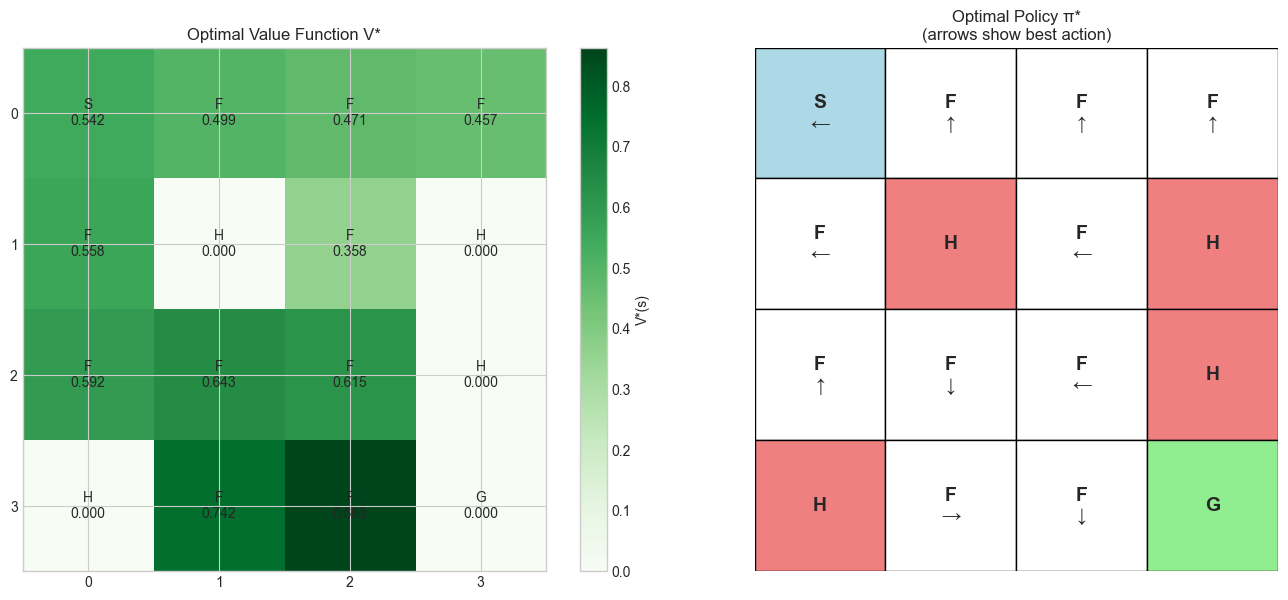

In [26]:
# Visualize optimal values and policy
print("**Question these plots answer:** 'What is the optimal value and policy for FrozenLake?'\n")

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot V*
desc = env.unwrapped.desc.astype(str)
nrow, ncol = desc.shape
V_grid = V_star.reshape(nrow, ncol)

im = axes[0].imshow(V_grid, cmap='Greens', vmin=0, vmax=V_star.max())
plt.colorbar(im, ax=axes[0], label='V*(s)')

for i in range(nrow):
    for j in range(ncol):
        state = i * ncol + j
        axes[0].text(j, i, f'{desc[i,j]}\n{V_star[state]:.3f}', 
                    ha='center', va='center', fontsize=10)

axes[0].set_title('Optimal Value Function V*', fontsize=12)
axes[0].set_xticks(range(ncol))
axes[0].set_yticks(range(nrow))

# Plot optimal policy
action_arrows = ['←', '↓', '→', '↑']
colors = {'S': 'lightblue', 'F': 'white', 'H': 'lightcoral', 'G': 'lightgreen'}

for i in range(nrow):
    for j in range(ncol):
        state = i * ncol + j
        cell = desc[i, j]
        
        rect = plt.Rectangle((j, nrow-1-i), 1, 1, fill=True,
                             facecolor=colors.get(cell, 'white'), edgecolor='black')
        axes[1].add_patch(rect)
        
        best_action = np.argmax(Q_star[state])
        if cell not in ['H', 'G']:
            axes[1].text(j + 0.5, nrow - 1 - i + 0.5, 
                        f'{cell}\n{action_arrows[best_action]}',
                        ha='center', va='center', fontsize=14, fontweight='bold')
        else:
            axes[1].text(j + 0.5, nrow - 1 - i + 0.5, cell,
                        ha='center', va='center', fontsize=14, fontweight='bold')

axes[1].set_xlim(0, ncol)
axes[1].set_ylim(0, nrow)
axes[1].set_aspect('equal')
axes[1].axis('off')
axes[1].set_title('Optimal Policy π*\n(arrows show best action)', fontsize=12)

plt.tight_layout()
plt.show()

In [27]:
# Compare random policy vs optimal policy performance
print("**Question this comparison answers:** 'How much better is the optimal policy?'\n")

def evaluate_policy(env, policy, n_episodes=10000):
    """Evaluate a policy by running episodes."""
    total_rewards = []
    
    for _ in range(n_episodes):
        obs, _ = env.reset()
        episode_reward = 0
        done = False
        
        while not done:
            action = np.random.choice(env.action_space.n, p=policy[obs])
            obs, reward, terminated, truncated, _ = env.step(action)
            episode_reward += reward
            done = terminated or truncated
        
        total_rewards.append(episode_reward)
    
    return total_rewards

# Evaluate both policies
env = gym.make("FrozenLake-v1", is_slippery=True)

print("Policy Comparison (10,000 episodes each)")
print("=" * 50)

rewards_random = evaluate_policy(env, pi_random, n_episodes=10000)
rewards_optimal = evaluate_policy(env, pi_star, n_episodes=10000)

print(f"\nRandom Policy:")
print(f"  Success rate: {np.mean(rewards_random)*100:.2f}%")

print(f"\nOptimal Policy:")
print(f"  Success rate: {np.mean(rewards_optimal)*100:.2f}%")

improvement = (np.mean(rewards_optimal) - np.mean(rewards_random)) / np.mean(rewards_random) * 100
print(f"\nImprovement: {improvement:.1f}% relative increase")

env.close()

**Question this comparison answers:** 'How much better is the optimal policy?'

Policy Comparison (10,000 episodes each)

Random Policy:
  Success rate: 1.28%

Optimal Policy:
  Success rate: 74.27%

Improvement: 5702.3% relative increase


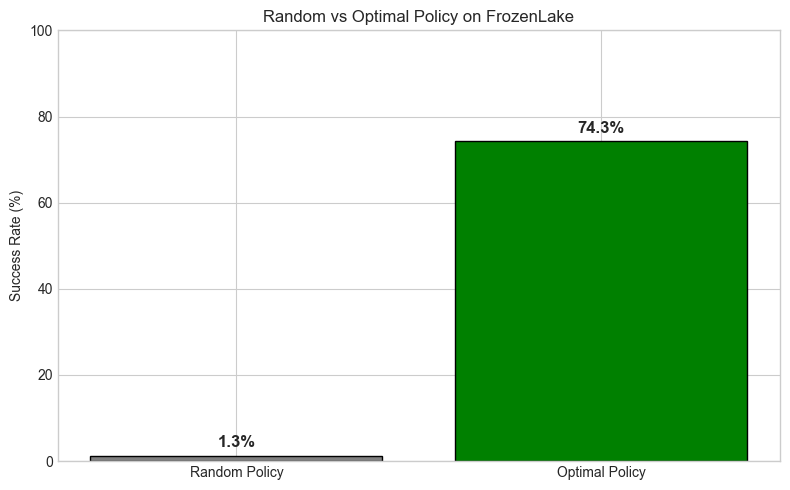

In [28]:
# Visualize the comparison
fig, ax = plt.subplots(figsize=(8, 5))

policies = ['Random Policy', 'Optimal Policy']
success_rates = [np.mean(rewards_random) * 100, np.mean(rewards_optimal) * 100]
colors = ['gray', 'green']

bars = ax.bar(policies, success_rates, color=colors, edgecolor='black')

ax.set_ylabel('Success Rate (%)')
ax.set_title('Random vs Optimal Policy on FrozenLake')
ax.set_ylim(0, 100)

for bar, rate in zip(bars, success_rates):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
            f'{rate:.1f}%', ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

> **Checkpoint — You should now understand:**
> - $V^*(s) = \max_\pi V^\pi(s)$ and $Q^*(s,a) = \max_\pi Q^\pi(s,a)$
> - The optimal policy is $\pi^*(s) = \arg\max_a Q^*(s,a)$
> - Bellman Optimality Equations use **max** instead of policy-weighted average
> - This non-linearity requires iterative solution methods

---
# 9. Summary and Concept Map

In this notebook, we built up the mathematical framework for reinforcement learning:

```
FROM SIMPLE TO COMPLEX: THE MDP HIERARCHY
==========================================

┌─────────────────────────────────────────────────────────────────┐
│  MARKOV PROCESS (Markov Chain)                                  │
│  ────────────────────────────                                   │
│  (S, P) - States and Transitions                                │
│  • Random walk through states                                   │
│  • No rewards, no actions                                       │
└─────────────────────────────────────────────────────────────────┘
                              ↓ Add Rewards
┌─────────────────────────────────────────────────────────────────┐
│  MARKOV REWARD PROCESS (MRP)                                    │
│  ────────────────────────────                                   │
│  (S, P, R, γ) - Add Rewards and Discount                        │
│  • Value function v(s) = E[G_t | S_t = s]                       │
│  • Bellman equation: v = R + γPv                                │
└─────────────────────────────────────────────────────────────────┘
                              ↓ Add Actions
┌─────────────────────────────────────────────────────────────────┐
│  MARKOV DECISION PROCESS (MDP)                                  │
│  ────────────────────────────                                   │
│  (S, A, P, R, γ) - The Full RL Framework                        │
│  • Policy π(a|s) defines behavior                               │
│  • V^π(s) and Q^π(s,a) value functions                          │
│  • Bellman Expectation: V = Σπ[R + γPV]                         │
│  • Bellman Optimality: V* = max[R + γPV*]                       │
└─────────────────────────────────────────────────────────────────┘


KEY EQUATIONS:
──────────────
Return:           G_t = R_{t+1} + γR_{t+2} + γ²R_{t+3} + ...

Value (MRP):      v(s) = R_s + γ Σ P_{ss'} v(s')

V^π (MDP):        V^π(s) = Σ_a π(a|s) [R_s^a + γ Σ_{s'} P_{ss'}^a V^π(s')]

Q^π (MDP):        Q^π(s,a) = R_s^a + γ Σ_{s'} P_{ss'}^a V^π(s')

V* (Optimal):     V*(s) = max_a [R_s^a + γ Σ_{s'} P_{ss'}^a V*(s')]

Optimal Policy:   π*(s) = argmax_a Q*(s,a)
```

## What's Coming Next

In the next notebook (**03_dynamic_programming.ipynb**), we'll learn algorithms to **solve** MDPs:

| Algorithm | Purpose | Requires Model? |
|-----------|---------|----------------|
| **Policy Evaluation** | Compute $V^\pi$ for a given policy | Yes |
| **Policy Iteration** | Find $\pi^*$ by alternating evaluation and improvement | Yes |
| **Value Iteration** | Find $V^*$ directly using Bellman Optimality | Yes |

These are **dynamic programming** methods that require knowing the MDP model (transitions and rewards).

---
# 10. Your Turn

Now it's time to test your understanding!

## Exercise 1: Conceptual Question

Consider the Bellman Expectation Equation for $V^\pi$:

$$V^\pi(s) = \sum_a \pi(a|s) \left[ R^a_s + \gamma \sum_{s'} P^a_{ss'} V^\pi(s') \right]$$

**Question:** Why does this equation have $V^\pi(s')$ on the right-hand side if we're trying to compute $V^\pi(s)$? Doesn't this create a circular dependency?

<details>
<summary>Click to see hint</summary>

Think about what "solving" a system of equations means. Consider a simple example with 2 states.

</details>

<details>
<summary>Click to see answer</summary>

**Yes, it's circular - and that's the point!**

The Bellman equation creates a **system of simultaneous equations**. For FrozenLake with 16 states, we have 16 equations (one per state), each relating $V(s)$ to the values of other states.

This system can be solved by:
1. **Matrix inversion**: Rearrange to $V = (I - \gamma P)^{-1} R$
2. **Iteration**: Start with a guess, repeatedly apply the Bellman update until convergence

The circular dependency is not a problem - it's what makes the equations capture the recursive nature of value!

</details>

## Exercise 2: Code Task

Verify the Bellman Optimality Equation for state 14 (adjacent to Goal).

**Task:** Compute $V^*(14)$ using the Bellman Optimality Equation and verify it matches the value from Value Iteration.

In [29]:
# YOUR CODE HERE
# Verify Bellman Optimality Equation for state 14

# state = 14
# gamma = 0.99

# print(f"Verifying Bellman Optimality Equation for State {state}")
# print("=" * 55)
# print(f"\nBellman Optimality: V*(s) = max_a [R(s,a) + γ × Σ P(s'|s,a) × V*(s')]")

# # For each action, compute Q*(s,a) = R(s,a) + γ × Σ P(s'|s,a) × V*(s')
# q_values = []
# for a in range(4):
#     # TODO: Compute q_value for this action
#     # q_value = R_mdp[state, a] + gamma * np.sum(T_mdp[state, a] * V_star)
#     # q_values.append(q_value)
#     pass

# # V*(s) = max over actions
# # v_star_calculated = max(q_values)

# # Compare with Value Iteration result
# # print(f"\nV*(14) from Bellman: {v_star_calculated:.6f}")
# # print(f"V*(14) from Value Iteration: {V_star[14]:.6f}")

## Exercise 3: Conceptual Question

**Question:** In FrozenLake, why is the optimal policy success rate (~74%) much lower than 100%, even though we found the "optimal" policy?

<details>
<summary>Click to see hint</summary>

Think about what "optimal" means in a stochastic environment.

</details>

<details>
<summary>Click to see answer</summary>

**"Optimal" means the best possible, not perfect.**

The optimal policy maximizes the expected return, but the environment is stochastic (slippery ice). Even with the best possible action choices:

1. The agent only moves in the intended direction 1/3 of the time
2. The other 2/3, it slips perpendicular to the intended direction
3. Some slips inevitably lead to Holes

No policy can overcome the inherent randomness in the environment. The optimal policy achieves ~74% because that's the theoretical maximum given the stochastic transitions.

Compare to the deterministic case (`is_slippery=False`) where the optimal policy achieves 100% success!

</details>

---
**Congratulations! You've completed Part 2 of the RL Tutorial!**

**Key takeaways:**
- MDPs $(S, A, P, R, \gamma)$ provide the mathematical framework for RL
- Value functions $V^\pi(s)$ and $Q^\pi(s,a)$ quantify long-term desirability
- Bellman Expectation Equations relate values recursively (for a given policy)
- Bellman Optimality Equations define optimal values (using max instead of policy average)
- The optimal policy simply picks $\arg\max_a Q^*(s,a)$

**Next: 03_dynamic_programming.ipynb** - Algorithms to solve MDPs!